# Prerequisites

In [1]:
import numpy as np
import pandas as pd
from tm import StockDataProvider
from tm.trading_rules import SimpleMovingAverage, ExponentialMovingAverage, STO, MACD, RSI, ROC, BollingerBaender
from tm.optimizers import GeneticOptimizer, StrategyPerformanceEvaluator, map_chromosome_to_trading_rule_parameters, filter_for_active_rules, calculate_absolute_buy_and_hold_returns
from tm.backtesting import GeometricBrownianMotion, MonteCarloCrossValidation
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

Define the trading rule basis for the strategy.

In [2]:
trading_rules = [SimpleMovingAverage, ExponentialMovingAverage, STO, MACD, RSI, ROC, BollingerBaender]

Define a function which finds the best strategy by running the genetic algorithm and applying backtesting.

In [3]:
# Returns best strategy as bitvector
def find_best_strategy(ticker_name, start, end, ngen=13):
    data = StockDataProvider(ticker_name, start=start, end=end)
    optimizer = GeneticOptimizer(data, trading_rules, random_seed=42)
    print('Running genetic algorithm ...')
    hof = optimizer.run(pop_size=1000, ngen=ngen, hof_size=100, mutpb=0.3)
    print('Net profit of buy and hold:', calculate_absolute_buy_and_hold_returns(data))
    gbm = GeometricBrownianMotion(data)
    crossvalidator = MonteCarloCrossValidation(hof, gbm, trading_rules)
    print('Running backtesting ...')
    best_individual = crossvalidator.run(num_iterations=100, time_steps=252)
    del data
    del optimizer
    del gbm
    del crossvalidator    
    return best_individual

Define a function which prints the results for the testing period.

In [4]:
def print_test_results(individual, ticker_name, start, end):
    real_data = StockDataProvider(ticker_name, start=start, end=end)
    rule_instances = list(map(lambda Rule, params: Rule(real_data, *params), trading_rules, map_chromosome_to_trading_rule_parameters(individual, trading_rules)))
    active_rule_instances = filter_for_active_rules(individual, rule_instances)
    evaluator = StrategyPerformanceEvaluator(active_rule_instances)
    net_profit, _ = evaluator.calculate_net_profit()
    net_profit_bh = calculate_absolute_buy_and_hold_returns(real_data)
    percentage_profit = net_profit / real_data.history['Close'].iloc[0] * 100
    percentage_profit_bh = net_profit_bh / real_data.history['Close'].iloc[0] * 100
    print('Active rules:', list(map(lambda rule: rule.__class__.__name__, active_rule_instances)))
    print('Active rules\' parameters:', list(map(lambda param: param[1], filter(lambda param: trading_rules[param[0]] in map(lambda rule: rule.__class__, active_rule_instances), enumerate(map_chromosome_to_trading_rule_parameters(individual, trading_rules))))))
    print('Net profit of strategy: {:f}'.format(net_profit))
    print('Net profit of buy and hold: {:f}'.format(net_profit_bh))
    print('Percentage profit of strategy: {:f}%'.format(percentage_profit))
    print('Percentage profit of buy and hold: {:f}%'.format(percentage_profit_bh))
    print('Number of buy signals:', len(evaluator.buy_signals[evaluator.buy_signals == True]))
    print('Number of sell signals:', len(evaluator.sell_signals[evaluator.sell_signals == True]))
    del real_data
    return evaluator, percentage_profit, percentage_profit_bh

Define a function which can plot a strategy.

In [5]:
def plot_strategy(evaluator, ticker_name, start, end):
    data = StockDataProvider(ticker_name, start=start, end=end)
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    ax.plot(data.history['Close'], label='Stock prices')

    if len(evaluator.buy_signals[evaluator.buy_signals == True]) > 0:
        buy_points = pd.Series(data=map(lambda index, price: price if evaluator.buy_signals.loc[index] == True else np.nan, data.history['Close'].index, data.history['Close']),
                               index=data.history['Close'].index)
        ax.scatter(x=buy_points.index, y=buy_points, color='green', marker='^', label='Buy signal')
    
    if len(evaluator.sell_signals[evaluator.sell_signals == True]) > 0:
        sell_points = pd.Series(data=map(lambda index, price: price if evaluator.sell_signals.loc[index] == True else np.nan, data.history['Close'].index, data.history['Close']),
                               index=data.history['Close'].index)
        ax.scatter(x=sell_points.index, y=sell_points, color='red', marker='v', label='Sell signal')

    ax.set_xlabel('Date')
    ax.set_ylabel('Stock price')
    ax.legend()
    fig.tight_layout()
    del data

# Experiments

In [6]:
results = {'EXS1.DE': [],
           'ADS.DE': [],
           'ALV.DE': [],
           'BAS.DE': [],
           'DBK.DE': [],
           'DTE.DE': [],
           'SAP.DE': [],
           'DJI': [],
           'CSCO': [],
           'DD': [],
           'JPM': [],
           'MSFT': [],
           'NKE': [],
           'UNH': []}

## DAX

In [7]:
%%time
best_individual = find_best_strategy(ticker_name='EXS1.DE', start='2016-01-01', end='2018-12-31', ngen=13)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-33.8137	28.6973	0.482015	3.92847
1  	647   	-8.18035	28.6973	1.50245 	5.22842
2  	648   	-10.3646	28.7313	2.46593 	6.42272
3  	669   	-8.85202	29.3729	4.84332 	8.5395 
4  	659   	-45.1675	32.787 	8.08897 	10.134 
5  	645   	-21.0105	32.787 	12.0626 	10.6815
6  	642   	-29.42  	32.787 	14.0607 	11.3073
7  	637   	-29.42  	32.787 	16.0558 	11.8971
8  	663   	-17.756 	33.9242	17.8926 	12.2275
9  	651   	-9.43577	33.9242	18.8391 	12.5508
10 	655   	-8.40138	33.9242	19.4472 	12.862 
11 	678   	-20.7951	33.9242	20.0819 	13.2528
12 	642   	-29.3457	34.4828	21.7507 	12.8761
13 	661   	-11.7479	34.4828	23.8905 	11.8898
Net profit of buy and hold: 1.519725000000013
Running backtesting ...
Best individual: [1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 

In [8]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='EXS1.DE', start='2019-01-01', end='2019-12-31')
results['EXS1.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['STO', 'ROC', 'BollingerBaender']
Active rules' parameters: [[225, 18], [53], [6, 1]]
Net profit of strategy: 0.000000
Net profit of buy and hold: 21.888200
Percentage profit of strategy: 0.000000%
Percentage profit of buy and hold: 24.010750%
Number of buy signals: 0
Number of sell signals: 0


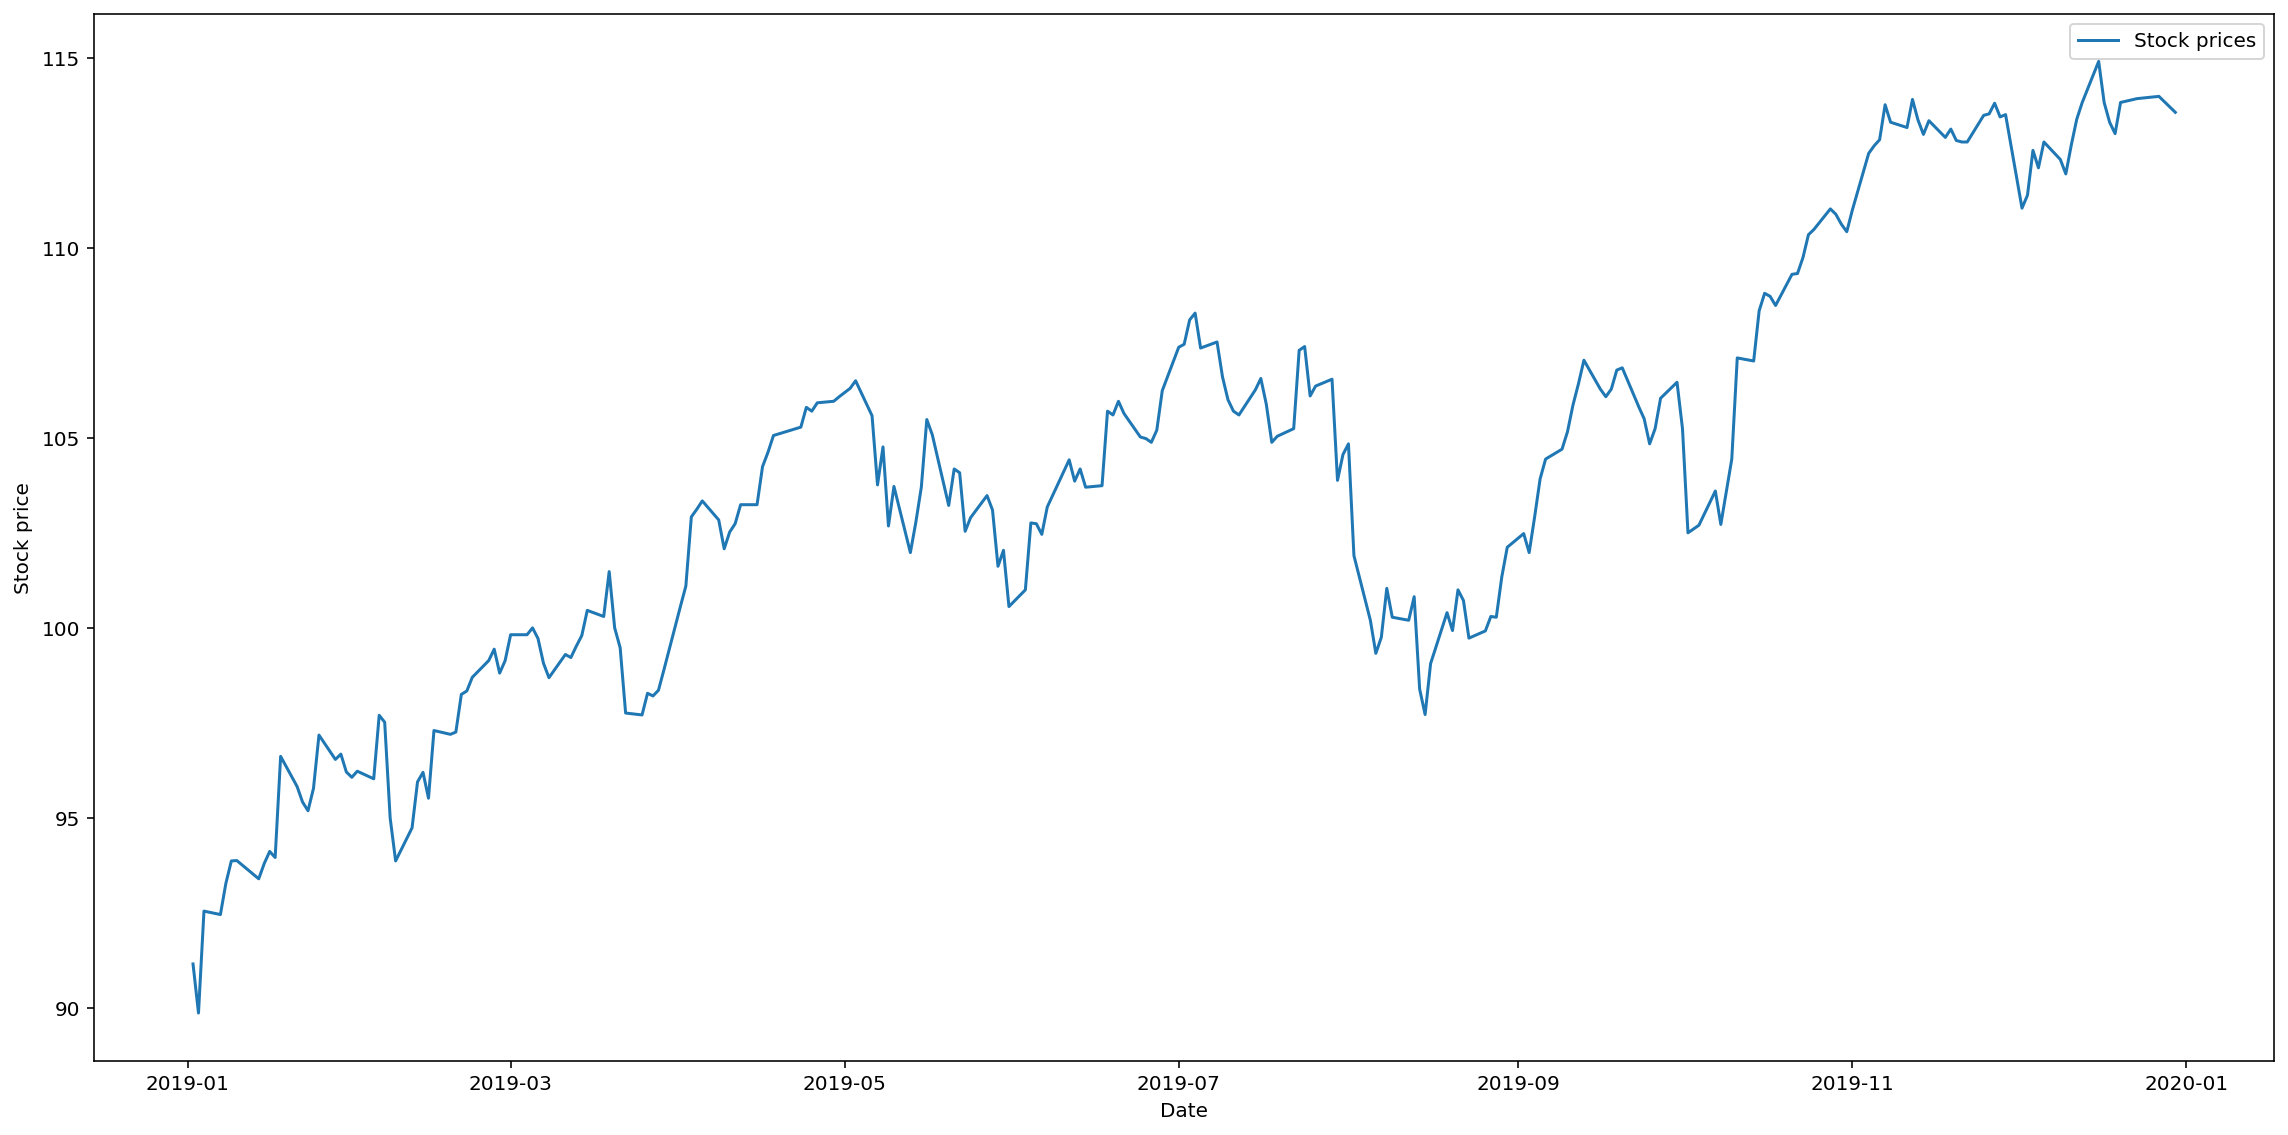

In [9]:
plot_strategy(evaluator, ticker_name='EXS1.DE', start='2019-01-01', end='2019-12-31')

## Adidas

In [10]:
%%time
best_individual = find_best_strategy(ticker_name='ADS.DE', start='2016-01-01', end='2018-12-31', ngen=13)

/Users/phipag/miniconda3/envs/trading_machine/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/phipag/miniconda3/envs/trading_machine/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Running genetic algorithm ...
gen	nevals	min     	max   	mean   	std    
0  	1000  	-16.6473	112.49	4.01392	18.1962
1  	647   	-14.5276	110.049	9.18098	26.2391
2  	648   	-28.3222	114.648	17.9873	34.8506
3  	669   	-22.7403	124.826	37.3282	43.7073
4  	659   	-9.5214 	124.826	56.7862	44.5494
5  	645   	-53.4907	124.826	70.6453	43.1569
6  	642   	-18.1857	124.826	76.4277	43.4358
7  	637   	-9.5214 	126.263	83.0473	42.4311
8  	663   	-17.7431	132.186	86.1376	42.4292
9  	651   	-44.2941	132.186	88.6673	42.1809
10 	655   	0       	133.386	90.4481	43.0497
11 	678   	0       	137.9  	92.1847	43.8579
12 	642   	0       	135.8  	98.093 	41.4123
13 	661   	0       	139.607	101.506	41.1024
Net profit of buy and hold: 95.468225
Running backtesting ...
Best individual: [1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0

In [11]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='ADS.DE', start='2019-01-01', end='2019-12-31')
results['ADS.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['STO', 'MACD', 'RSI', 'BollingerBaender']
Active rules' parameters: [[19, 162], [3, 45, 29], [3, 14, 59], [7, 0]]
Net profit of strategy: 61.335275
Net profit of buy and hold: 104.593925
Percentage profit of strategy: 34.392326%
Percentage profit of buy and hold: 58.648607%
Number of buy signals: 5
Number of sell signals: 5


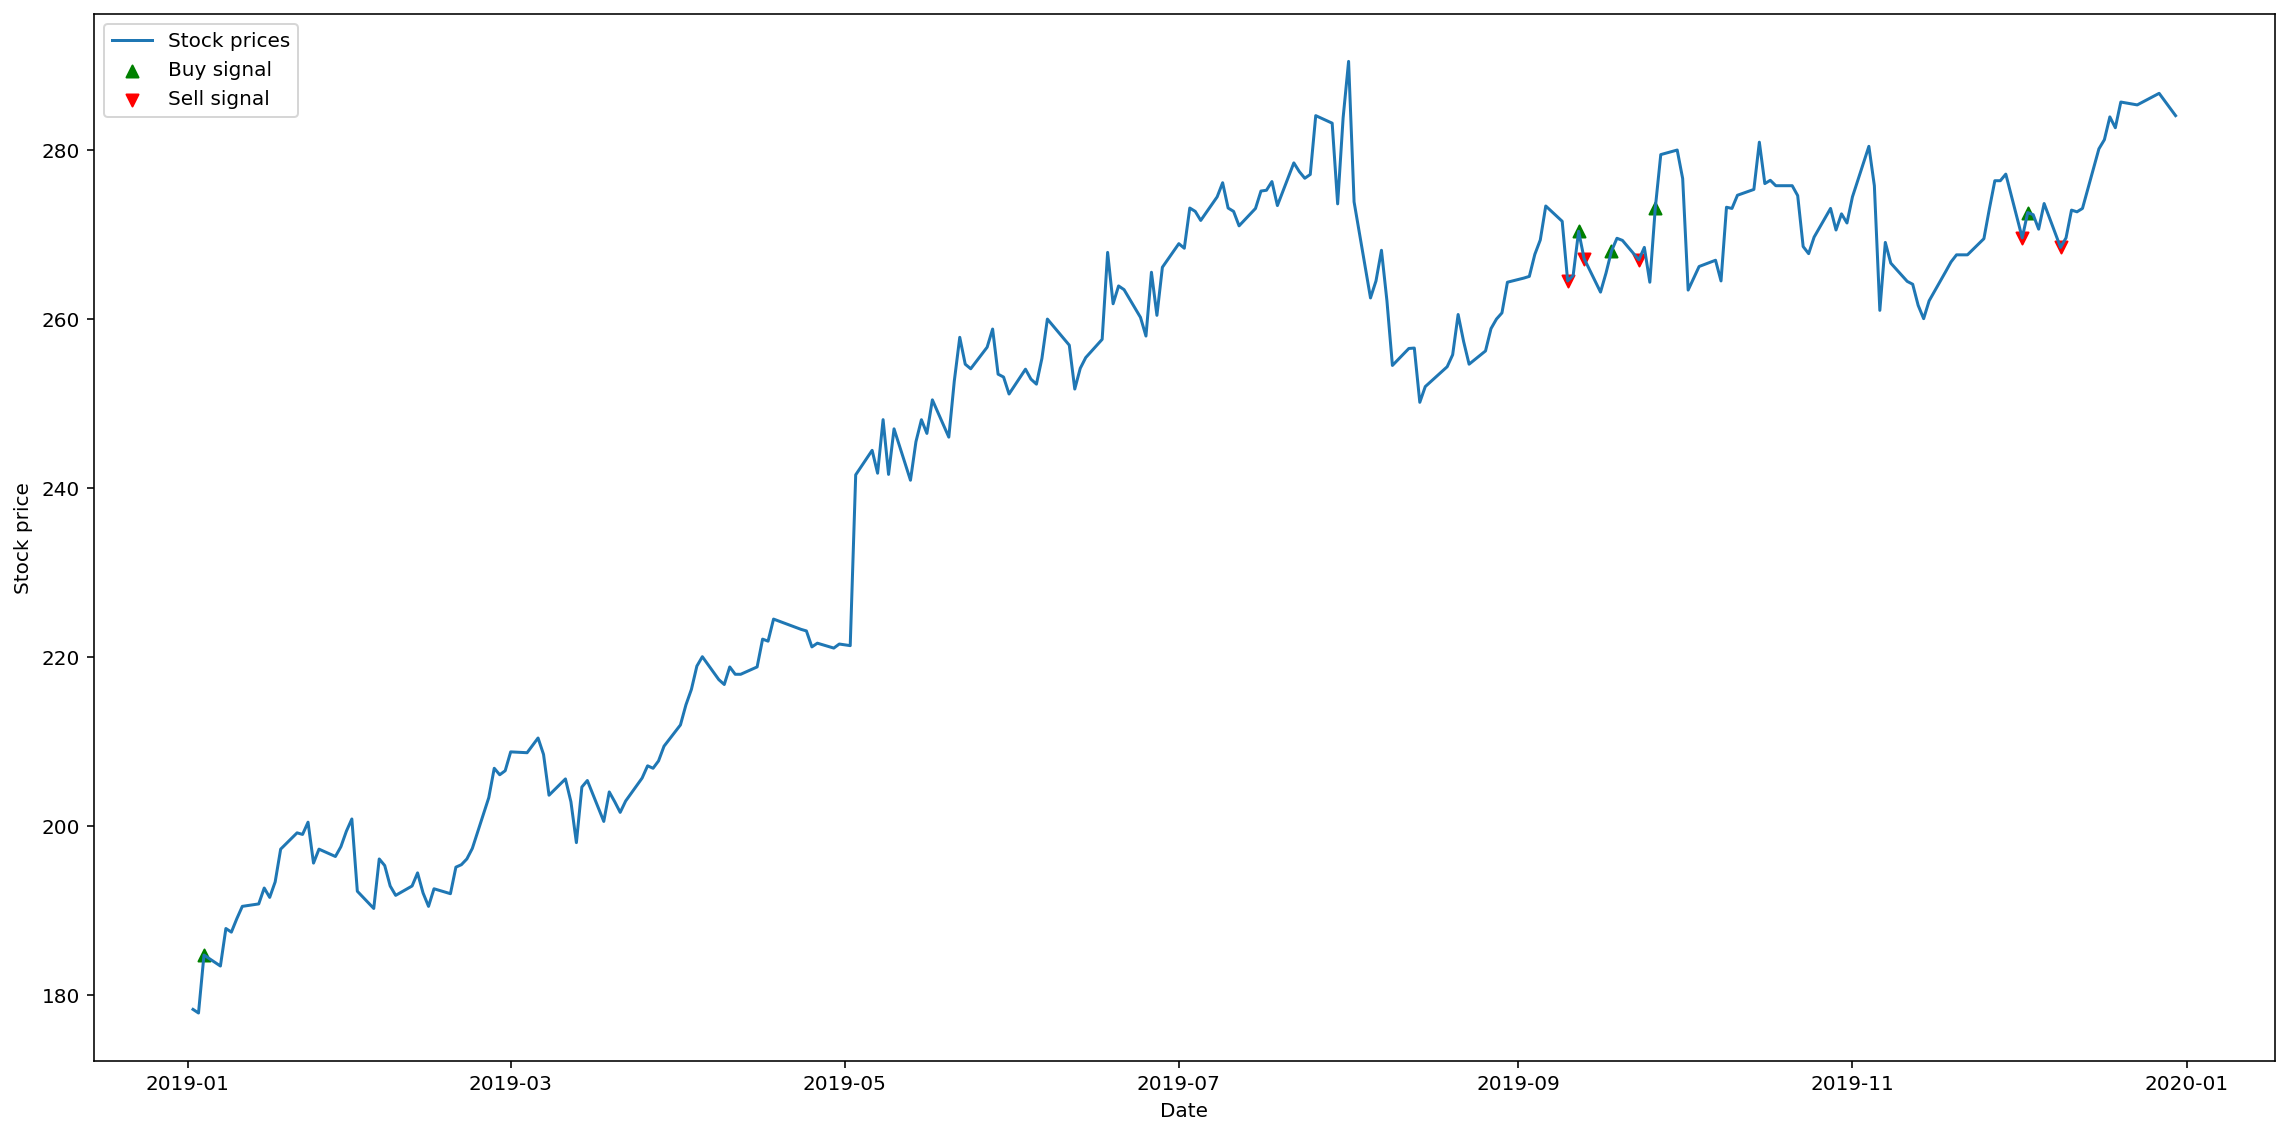

In [12]:
plot_strategy(evaluator, ticker_name='ADS.DE', start='2019-01-01', end='2019-12-31')

## Allianz

In [13]:
%%time
best_individual = find_best_strategy(ticker_name='ALV.DE', start='2016-01-01', end='2018-12-31', ngen=13)

Running genetic algorithm ...
gen	nevals	min     	max    	mean   	std    
0  	1000  	-12.3836	61.1142	2.63173	11.3015
1  	647   	-12.3836	67.2504	6.93995	17.3808
2  	648   	-33.4117	73.4153	13.4925	22.5079
3  	669   	-12.3836	73.4153	25.4598	25.8418
4  	659   	-18.7887	79.3148	36.3655	25.3058
5  	645   	-29.4982	79.3148	42.7402	24.6053
6  	642   	-19.6686	79.3148	45.5064	25.218 
7  	637   	-12.7044	79.3148	48.9783	24.9622
8  	663   	-18.7887	79.3148	49.1867	26.2495
9  	651   	-10.93  	79.3148	50.4016	26.914 
10 	655   	-26.4467	79.3148	51.125 	27.4875
11 	678   	-22.6154	79.3148	53.1656	26.7037
12 	642   	-12.9926	79.3148	54.3585	26.8667
13 	661   	-14.5743	79.3148	57.2079	27.1142
Net profit of buy and hold: 40.68527499999999
Running backtesting ...
Best individual: [0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 

In [14]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='ALV.DE', start='2019-01-01', end='2019-12-31')
results['ALV.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['MACD', 'BollingerBaender']
Active rules' parameters: [[49, 20, 55], [15, 0]]
Net profit of strategy: 30.702900
Net profit of buy and hold: 47.002725
Percentage profit of strategy: 19.493905%
Percentage profit of buy and hold: 29.843000%
Number of buy signals: 1
Number of sell signals: 1


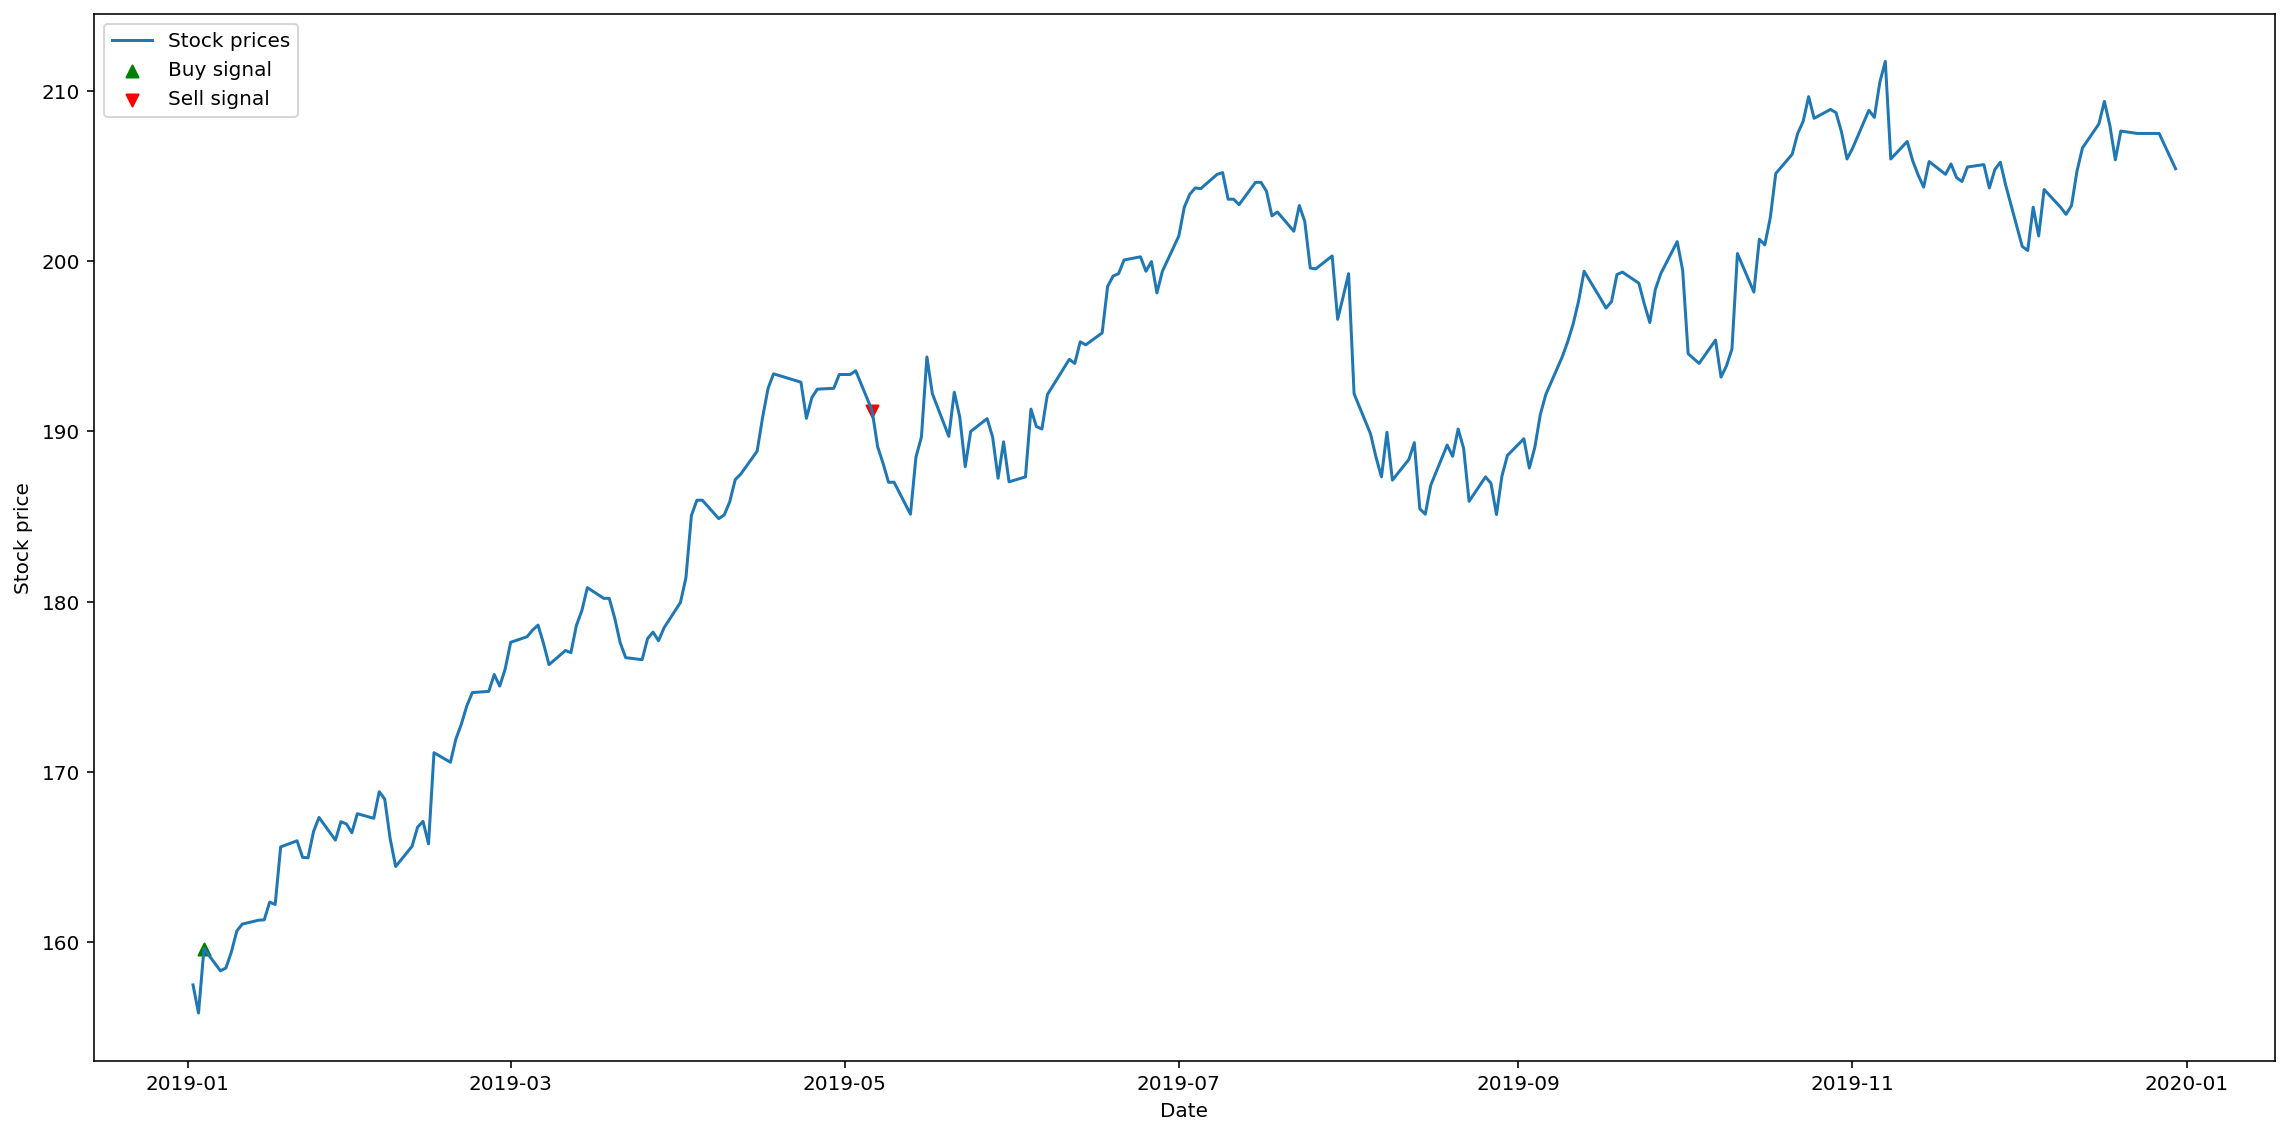

In [15]:
plot_strategy(evaluator, ticker_name='ALV.DE', start='2019-01-01', end='2019-12-31')

## BASF

In [16]:
%%time
best_individual = find_best_strategy(ticker_name='BAS.DE', start='2016-01-01', end='2018-12-31', ngen=13)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-22.1554	31.5457	0.523182	3.67837
1  	647   	-17.9184	31.5457	1.23613 	5.01668
2  	648   	-13.2035	30.2901	2.52043 	6.91054
3  	669   	-14.9614	30.2901	4.794   	8.87301
4  	659   	-9.73662	30.2901	8.02337 	10.364 
5  	645   	-25.719 	30.2901	12.112  	11.2804
6  	642   	-28.2675	30.2901	14.7341 	11.3772
7  	637   	-16.8992	30.3963	16.6012 	11.5002
8  	663   	-16.1029	30.2901	18.244  	11.6751
9  	651   	-17.4254	30.2901	19.8731 	11.7204
10 	655   	-6.39352	31.8139	21.0209 	11.8695
11 	678   	-13.3268	31.8139	22.1736 	11.7651
12 	642   	-0.597075	31.8139	23.132  	11.5656
13 	661   	-7.3451  	31.8139	23.1036 	11.9465
Net profit of buy and hold: -0.29204999999999914
Running backtesting ...
Best individual: [0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0

In [17]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='BAS.DE', start='2019-01-01', end='2019-12-31')
results['BAS.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['SimpleMovingAverage', 'STO', 'MACD', 'BollingerBaender']
Active rules' parameters: [[51], [50, 26], [11, 27, 61], [7, 1]]
Net profit of strategy: 0.000000
Net profit of buy and hold: 7.846450
Percentage profit of strategy: 0.000000%
Percentage profit of buy and hold: 15.491510%
Number of buy signals: 0
Number of sell signals: 0


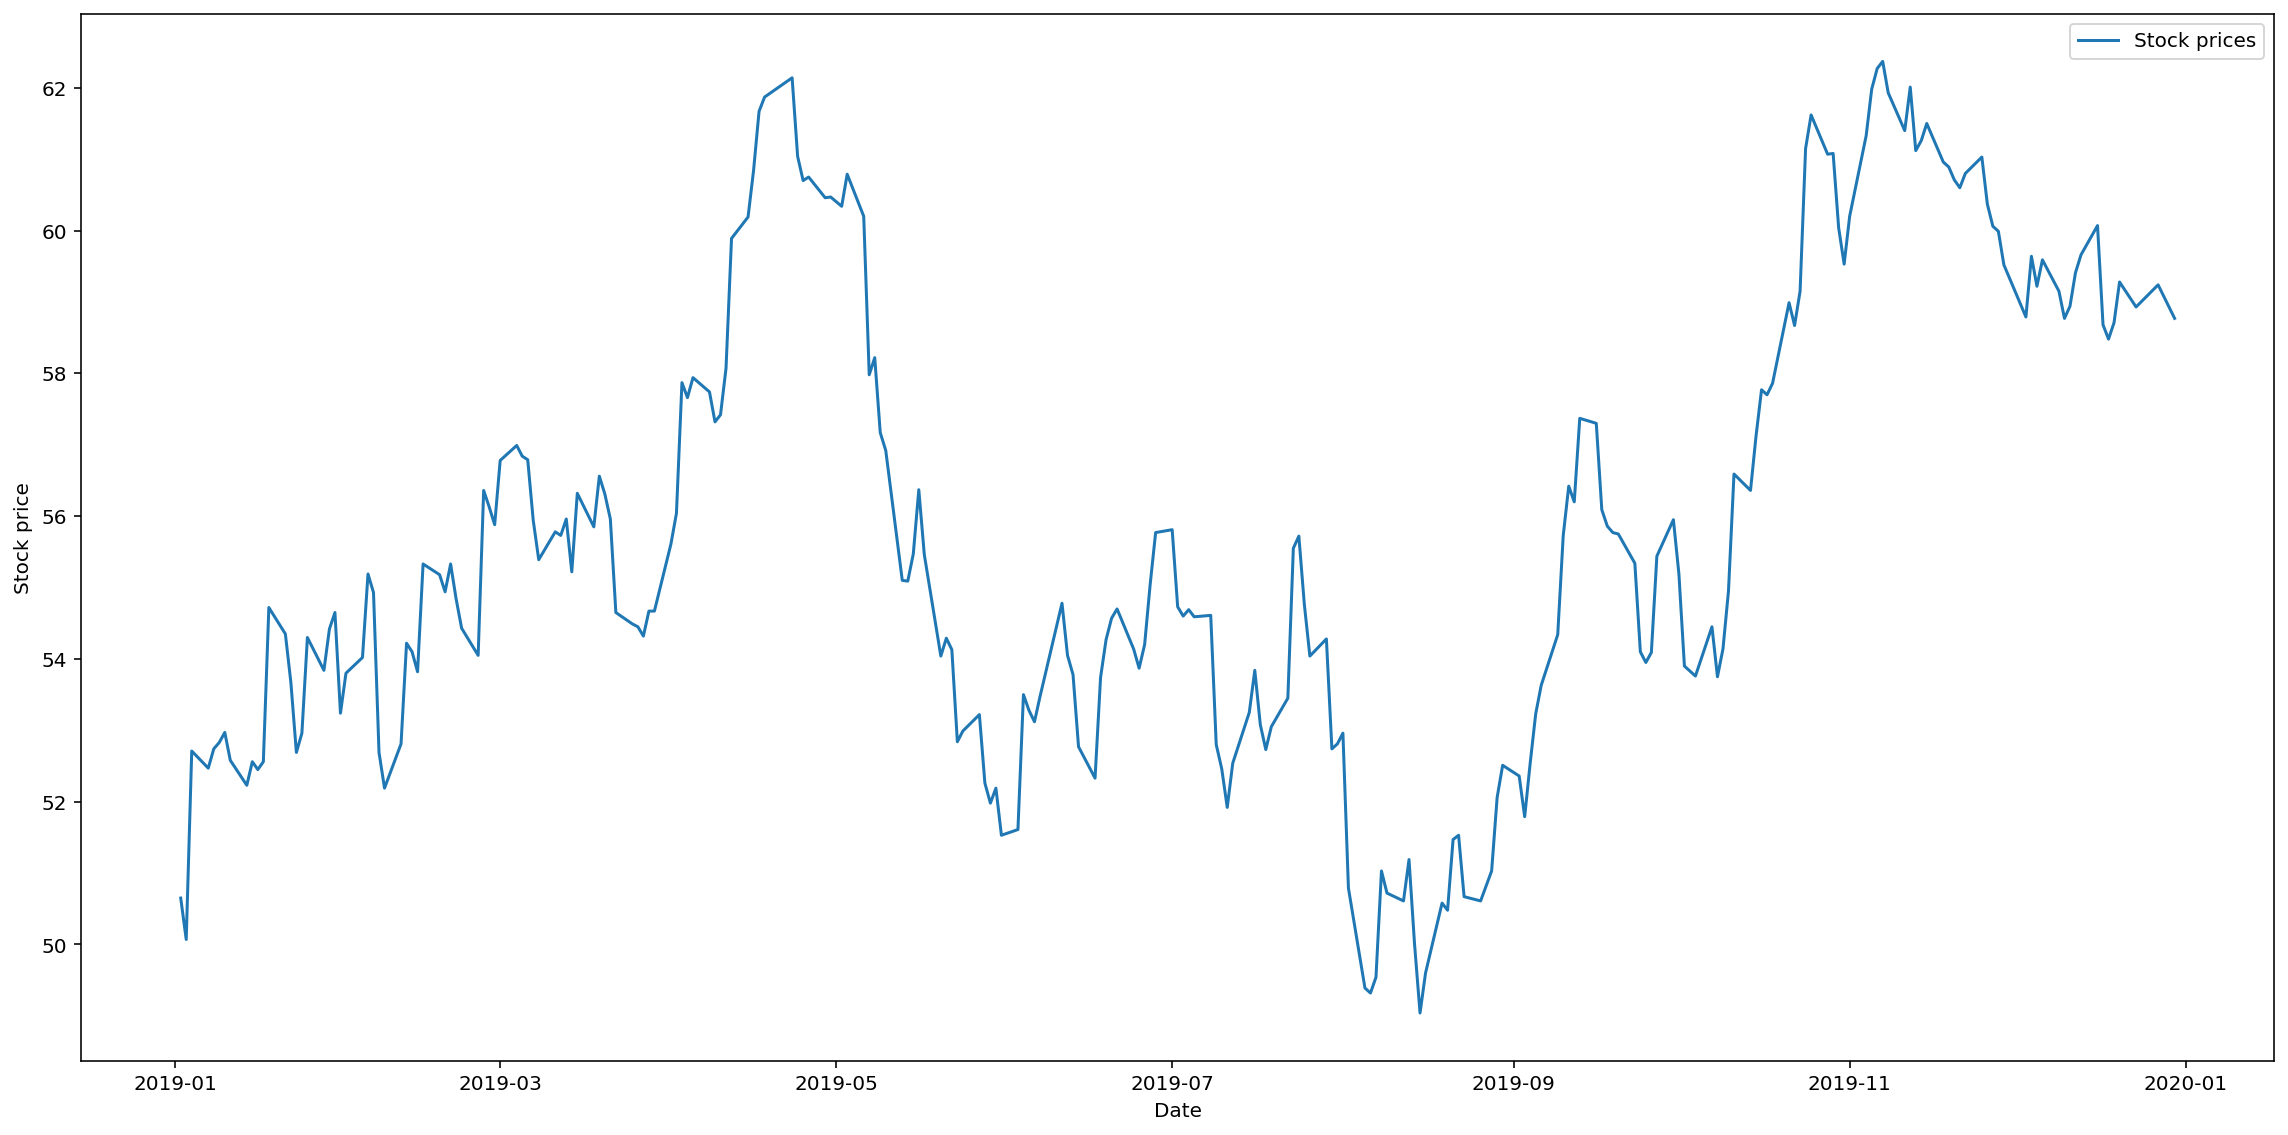

In [18]:
plot_strategy(evaluator, ticker_name='BAS.DE', start='2019-01-01', end='2019-12-31')

## Deutsche Bank

In [19]:
%%time
best_individual = find_best_strategy(ticker_name='DBK.DE', start='2016-01-01', end='2018-12-31', ngen=13)

Running genetic algorithm ...
gen	nevals	min     	max    	mean     	std     
0  	1000  	-10.0074	2.89545	-0.103902	0.913656
1  	647   	-8.57353	3.63375	0.0129038	0.662792
2  	648   	-8.48248	3.63375	0.0350563	0.814574
3  	669   	-9.3567 	3.63375	0.145087 	0.973187
4  	659   	-10.9453	4.41438	0.30614  	1.36582 
5  	645   	-10.6786	4.41438	0.585569 	1.58116 
6  	642   	-10.475 	4.41438	1.00653  	1.82307 
7  	637   	-8.42338	4.41438	1.48377  	1.87051 
8  	663   	-7.61892	5.10743	1.86483  	1.93739 
9  	651   	-9.58702	5.614  	2.12216  	1.88124 
10 	655   	-7.42855	5.614  	2.28255  	2.03554 
11 	678   	-10.6866	5.614  	2.44806  	2.13058 
12 	642   	-8.82822	5.8947 	2.66747  	2.11561 
13 	661   	-8.4597 	5.8947 	2.95938  	2.07638 
Net profit of buy and hold: -11.62315
Running backtesting ...
Best individual: [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,

In [20]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='DBK.DE', start='2019-01-01', end='2019-12-31')
results['DBK.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['STO', 'ROC', 'BollingerBaender']
Active rules' parameters: [[167, 190], [112], [32, 0]]
Net profit of strategy: 0.000000
Net profit of buy and hold: -0.144875
Percentage profit of strategy: 0.000000%
Percentage profit of buy and hold: -2.060811%
Number of buy signals: 0
Number of sell signals: 0


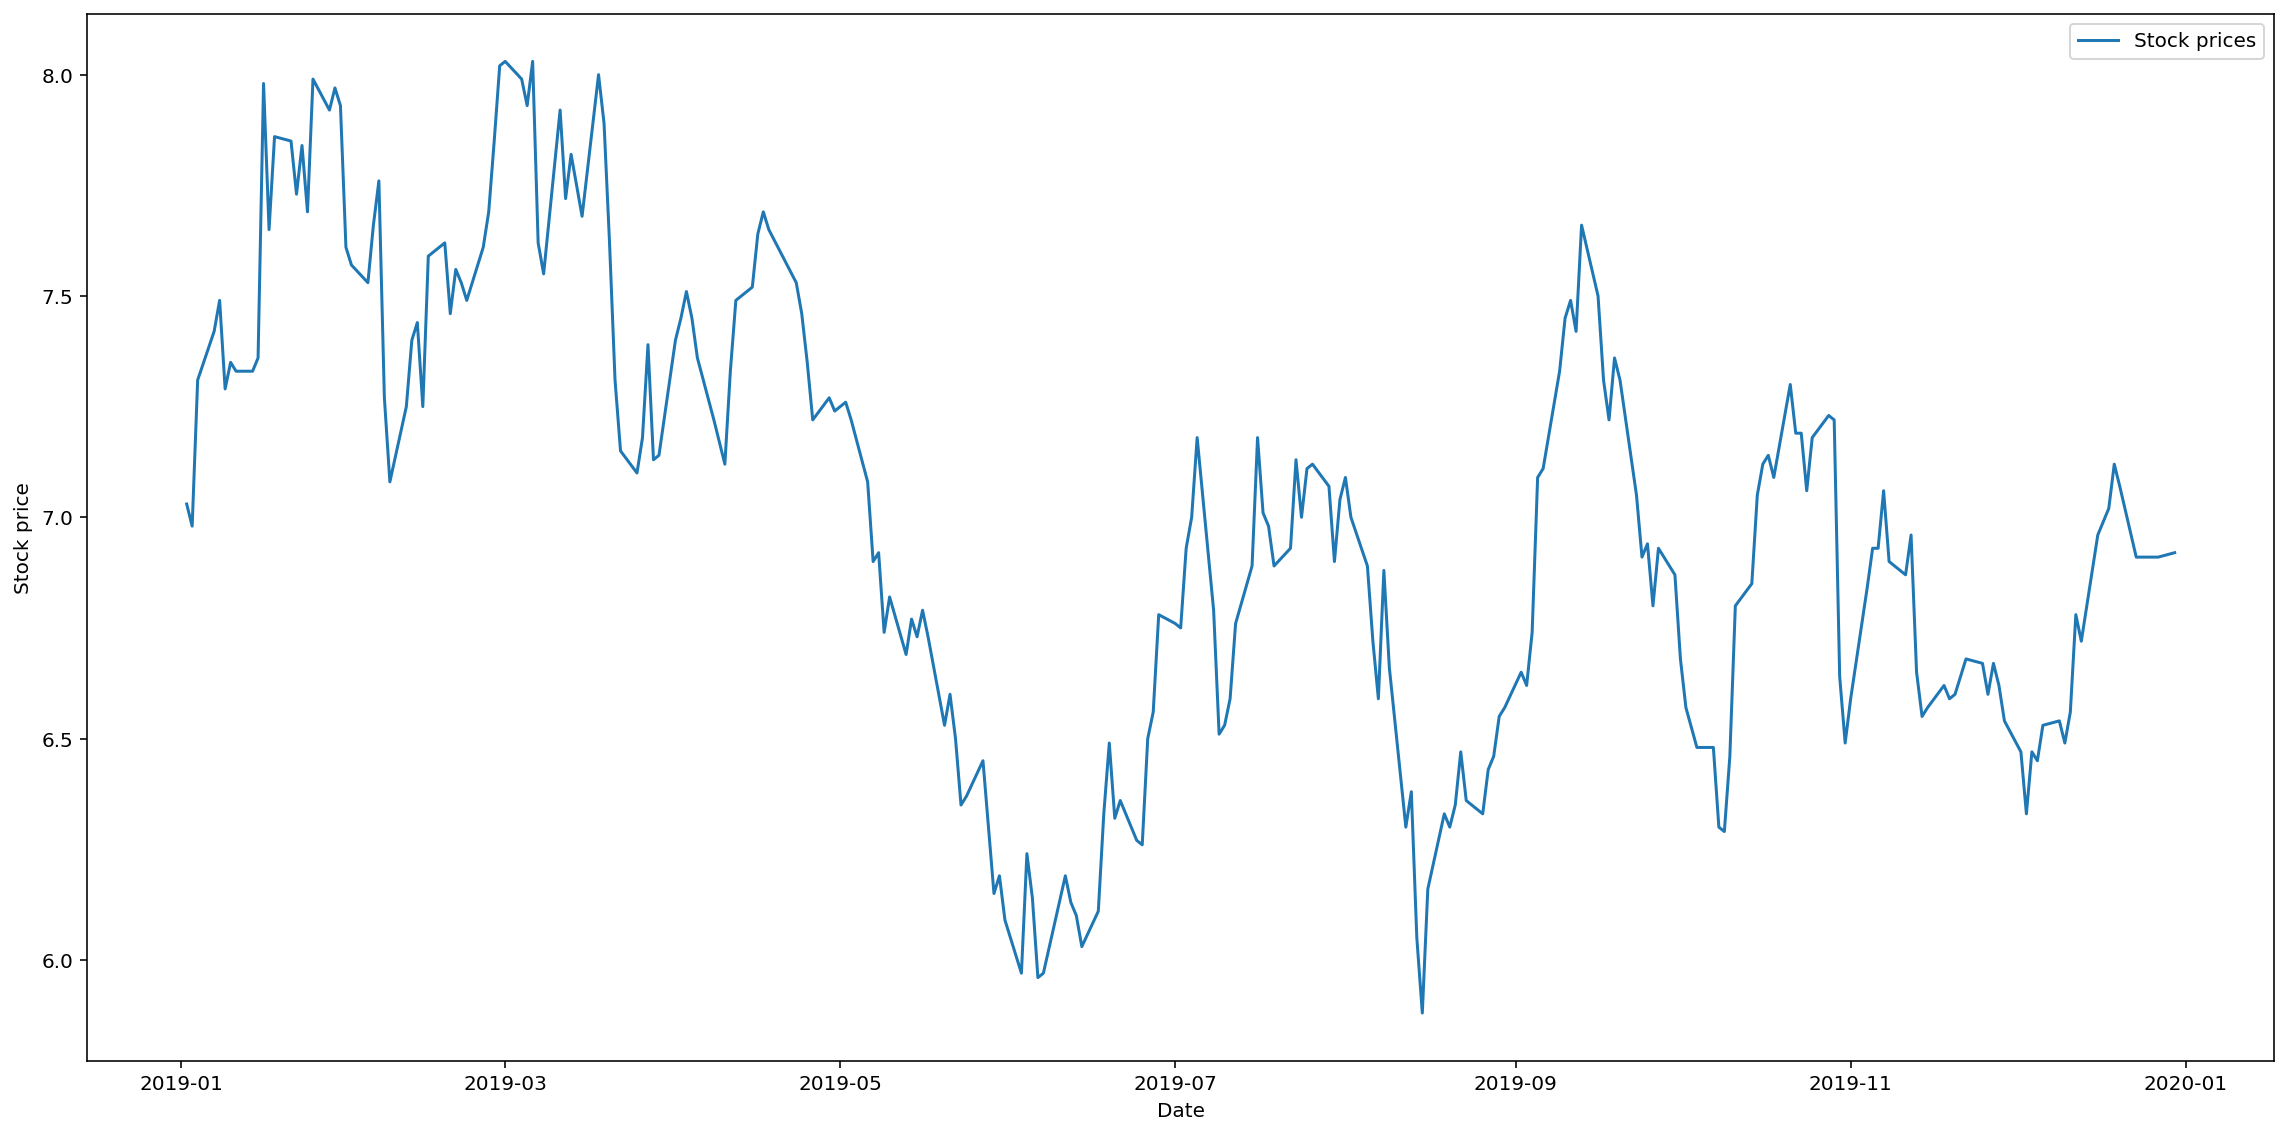

In [21]:
plot_strategy(evaluator, ticker_name='DBK.DE', start='2019-01-01', end='2019-12-31')

## Deutsche Telekom

In [22]:
%%time
best_individual = find_best_strategy(ticker_name='DTE.DE', start='2016-01-01', end='2018-12-31', ngen=13)

Running genetic algorithm ...
gen	nevals	min     	max   	mean     	std     
0  	1000  	-6.06657	2.6994	0.0170773	0.315672
1  	647   	-1.9338 	2.36403	0.0750765	0.328661
2  	648   	-1.27253	2.63305	0.143131 	0.429093
3  	669   	-1.9729 	2.82207	0.291216 	0.596098
4  	659   	-2.31622	2.82207	0.533908 	0.714862
5  	645   	-3.79958	3.29618	0.819364 	0.784834
6  	642   	-4.7582 	3.29618	0.96412  	0.828169
7  	637   	-3.2529 	3.29618	1.1213   	0.832665
8  	663   	-2.85763	4.01835	1.26015  	0.883293
9  	651   	-2.65163	4.01835	1.37539  	0.950016
10 	655   	-2.83385	4.01835	1.46392  	1.04144 
11 	678   	-3.28385	4.36683	1.59708  	1.13335 
12 	642   	-3.1576 	4.36683	1.80454  	1.20665 
13 	661   	-3.21577	4.47495	1.91037  	1.2988  
Net profit of buy and hold: 1.6496749999999991
Running backtesting ...
Best individual: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0

In [23]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='DTE.DE', start='2019-01-01', end='2019-12-31')
results['DTE.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['SimpleMovingAverage', 'RSI', 'BollingerBaender']
Active rules' parameters: [[0], [35, 119, 59], [4, 1]]
Net profit of strategy: 0.000000
Net profit of buy and hold: 0.314450
Percentage profit of strategy: 0.000000%
Percentage profit of buy and hold: 2.433824%
Number of buy signals: 0
Number of sell signals: 0


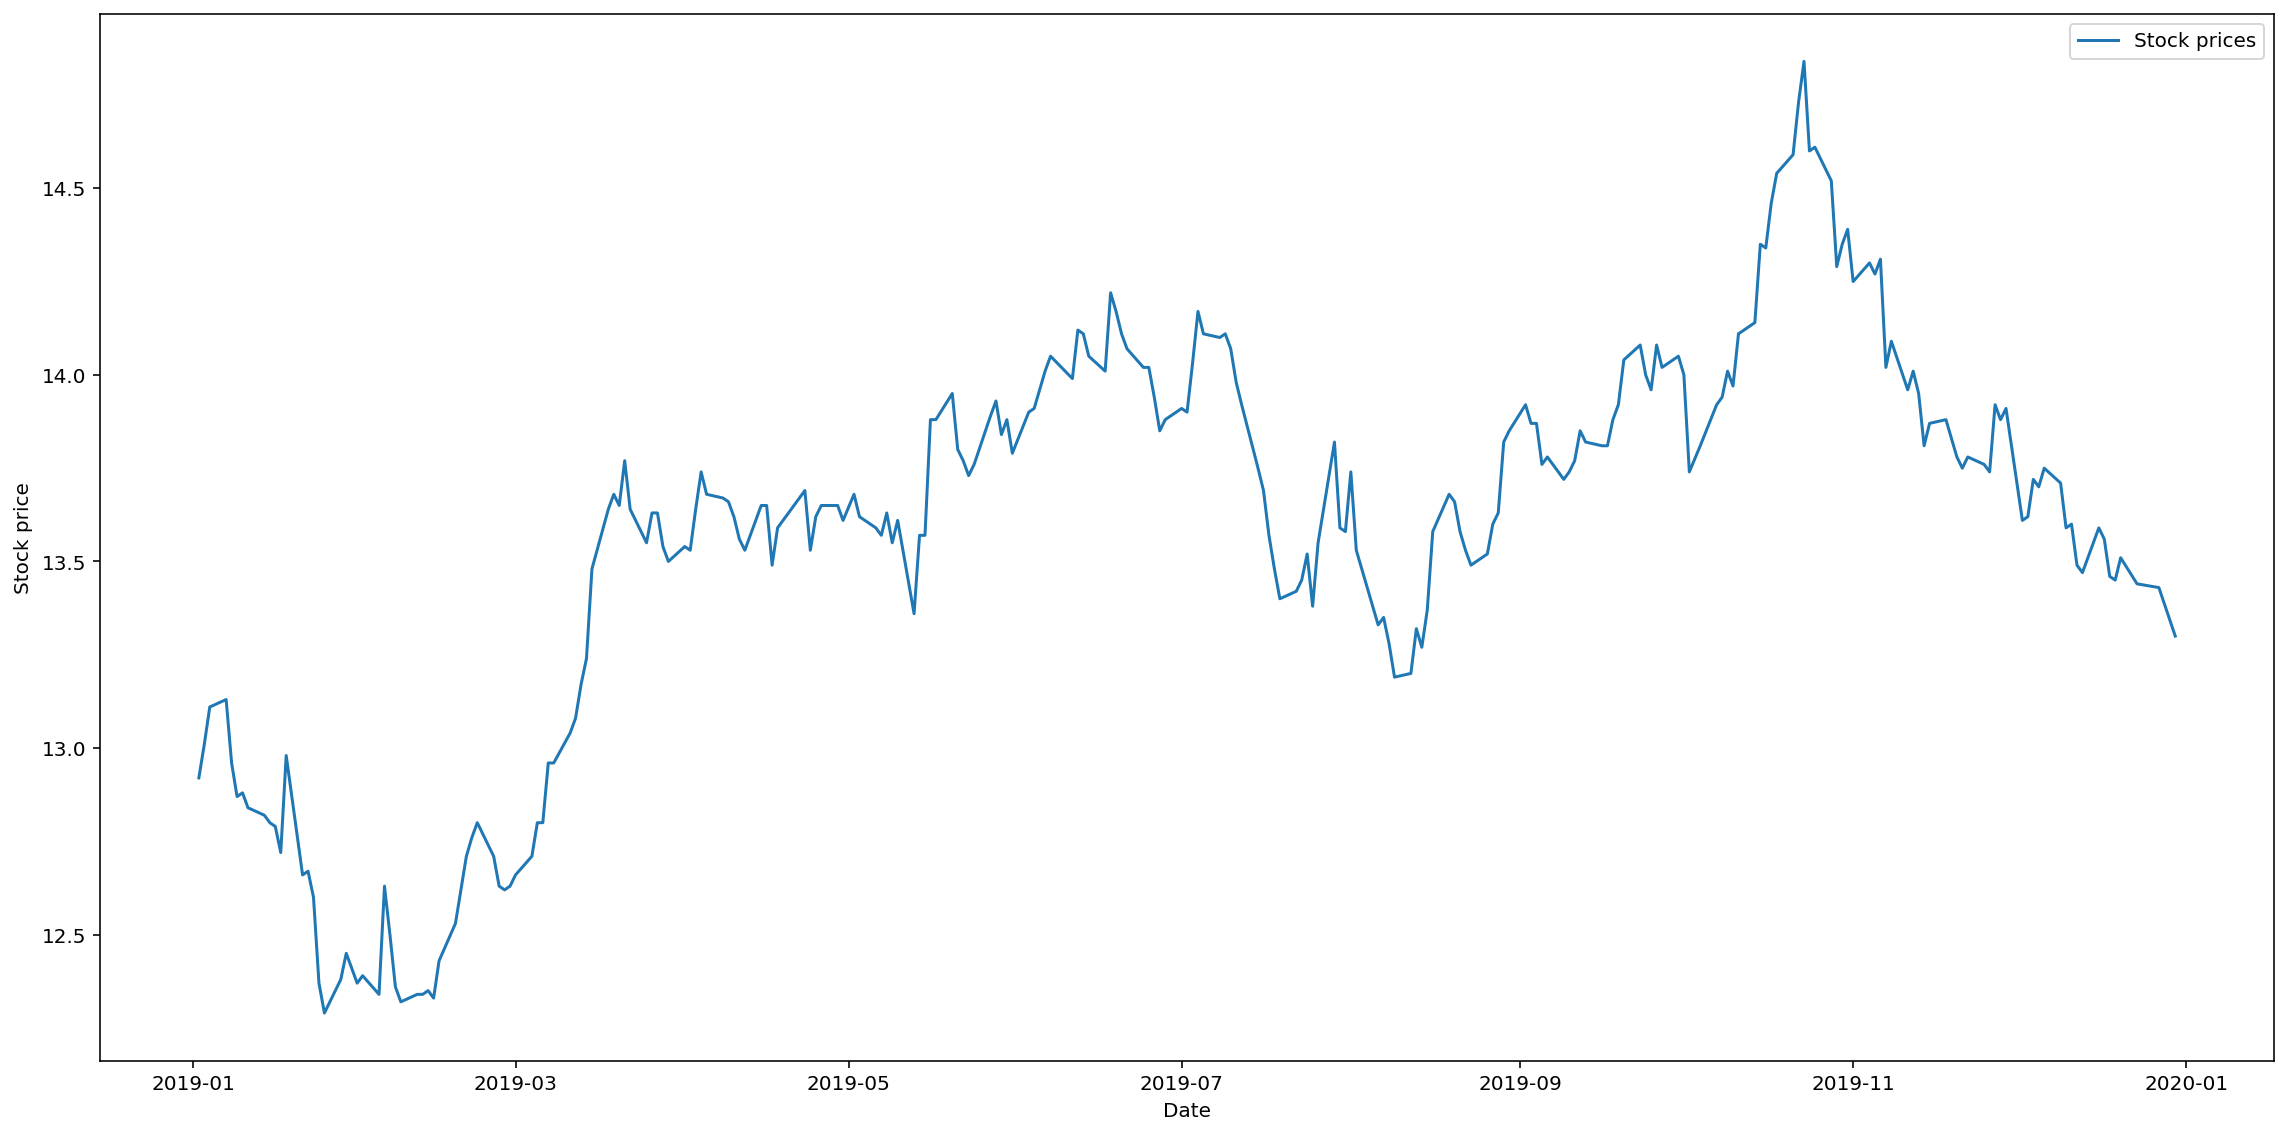

In [24]:
plot_strategy(evaluator, ticker_name='DTE.DE', start='2019-01-01', end='2019-12-31')

## SAP

In [25]:
%%time
best_individual = find_best_strategy(ticker_name='SAP.DE', start='2016-01-01', end='2018-12-31', ngen=13)

Running genetic algorithm ...
gen	nevals	min    	max   	mean    	std   
0  	1000  	-8.2308	31.211	0.699579	4.2397
1  	647   	-10.7281	35.2162	1.91785 	6.65646
2  	648   	-14.1609	36.1754	3.63431 	8.90684
3  	669   	-14.1609	39.2062	7.03925 	11.3613
4  	659   	-10.7281	39.2062	11.8951 	12.8697
5  	645   	-14.1609	40.2322	16.3407 	13.1642
6  	642   	-14.1609	41.3596	20.5537 	12.6912
7  	637   	-12.3299	41.3596	22.7872 	12.5337
8  	663   	-5.29735	41.3596	23.8197 	12.7876
9  	651   	-12.3299	41.3596	25.8644 	12.5367
10 	655   	-12.3299	41.3596	25.5846 	13.9374
11 	678   	-9.6753 	41.3596	27.1403 	13.69  
12 	642   	-11.7015	41.3596	29.0168 	13.3059
13 	661   	-11.7015	41.3596	30.1746 	13.1516
Net profit of buy and hold: 18.250100000000003
Running backtesting ...
Best individual: [0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,

In [26]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='SAP.DE', start='2019-01-01', end='2019-12-31')
results['SAP.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['MACD', 'BollingerBaender']
Active rules' parameters: [[17, 30, 63], [14, 0]]
Net profit of strategy: 15.532225
Net profit of buy and hold: 32.969475
Percentage profit of strategy: 18.630473%
Percentage profit of buy and hold: 39.545970%
Number of buy signals: 2
Number of sell signals: 2


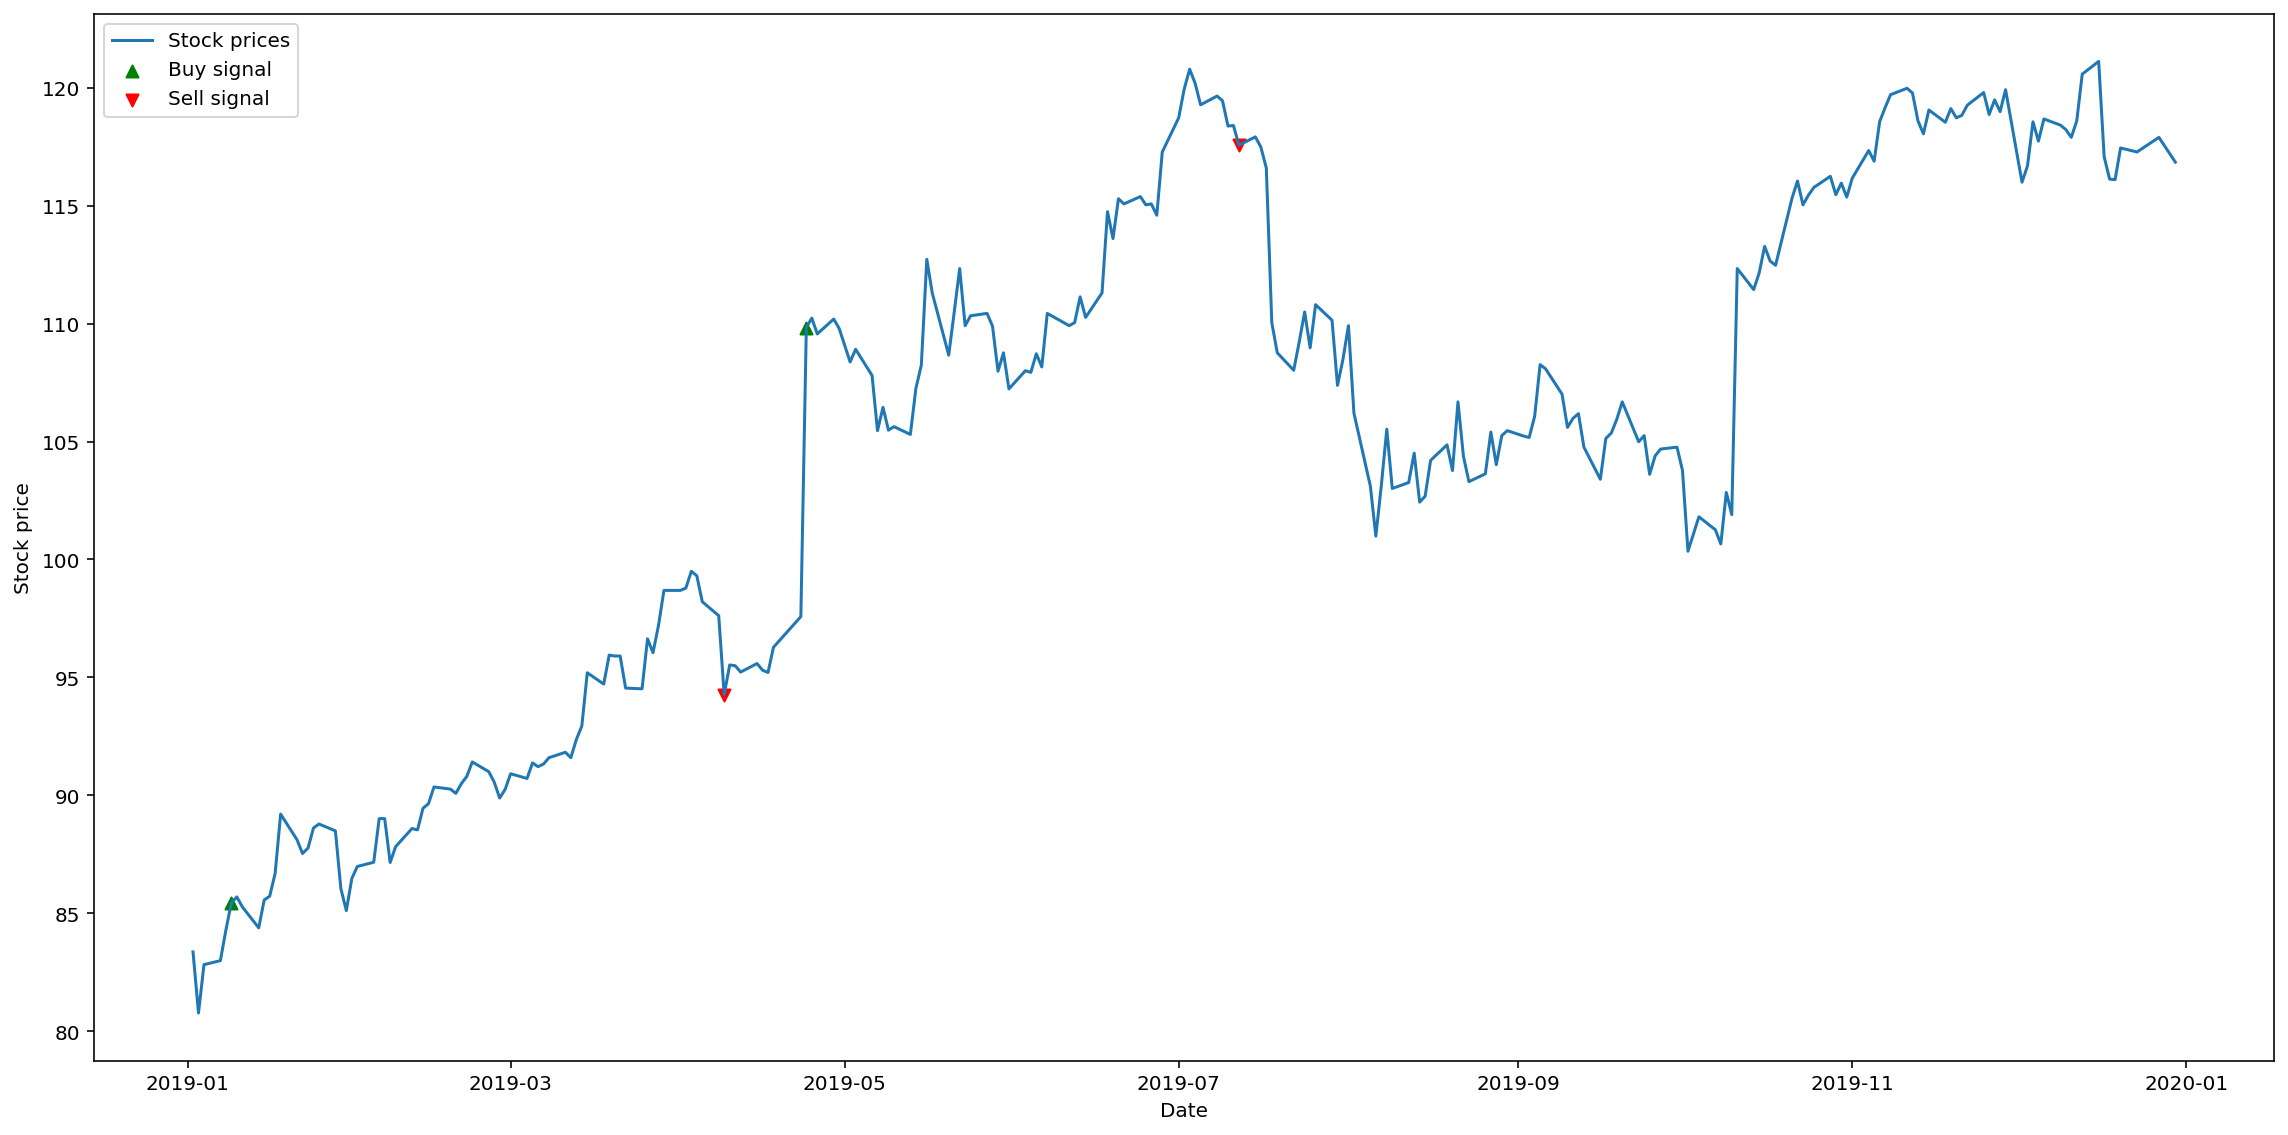

In [27]:
plot_strategy(evaluator, ticker_name='SAP.DE', start='2019-01-01', end='2019-12-31')

## Dow Jones Index

In [28]:
%%time
best_individual = find_best_strategy(ticker_name='DJI', start='2016-01-01', end='2018-12-31', ngen=13)

Running genetic algorithm ...
gen	nevals	min     	max    	mean  	std    
0  	1000  	-3202.47	8643.15	235.08	1246.19
1  	647   	-420.482	9080.27	513.295	1820.93
2  	648   	-407.503	9080.27	927.084	2316.87
3  	669   	-2290.61	9086.84	1734.23	2891.62
4  	659   	-492.114	9101.72	3302.99	3364.77
5  	645   	-2384.06	9190   	4858.23	3355.97
6  	642   	-558.457	9289.19	5454.02	3372.78
7  	637   	-3770.47	9289.19	5986.44	3442.01
8  	663   	-1002.32	9297.81	6261.49	3517.05
9  	651   	0       	9297.81	6650.7 	3486.47
10 	655   	-685.384	9297.81	6735.93	3687.4 
11 	678   	0       	9297.81	6957.02	3618.38
12 	642   	-685.384	9297.81	6960.77	3738.98
13 	661   	-420.135	9297.81	6977.91	3776.64
Net profit of buy and hold: 5812.97175
Running backtesting ...
Best individual: [0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 

In [29]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='DJI', start='2019-01-01', end='2019-12-31')
results['DJI'].append([percentage_profit, percentage_profit_bh])

Active rules: ['STO', 'MACD', 'ROC', 'BollingerBaender']
Active rules' parameters: [[112, 98], [51, 45, 20], [22], [2, 0]]
Net profit of strategy: 0.000000
Net profit of buy and hold: 2519.888500
Percentage profit of strategy: 0.000000%
Percentage profit of buy and hold: 10.796114%
Number of buy signals: 0
Number of sell signals: 0


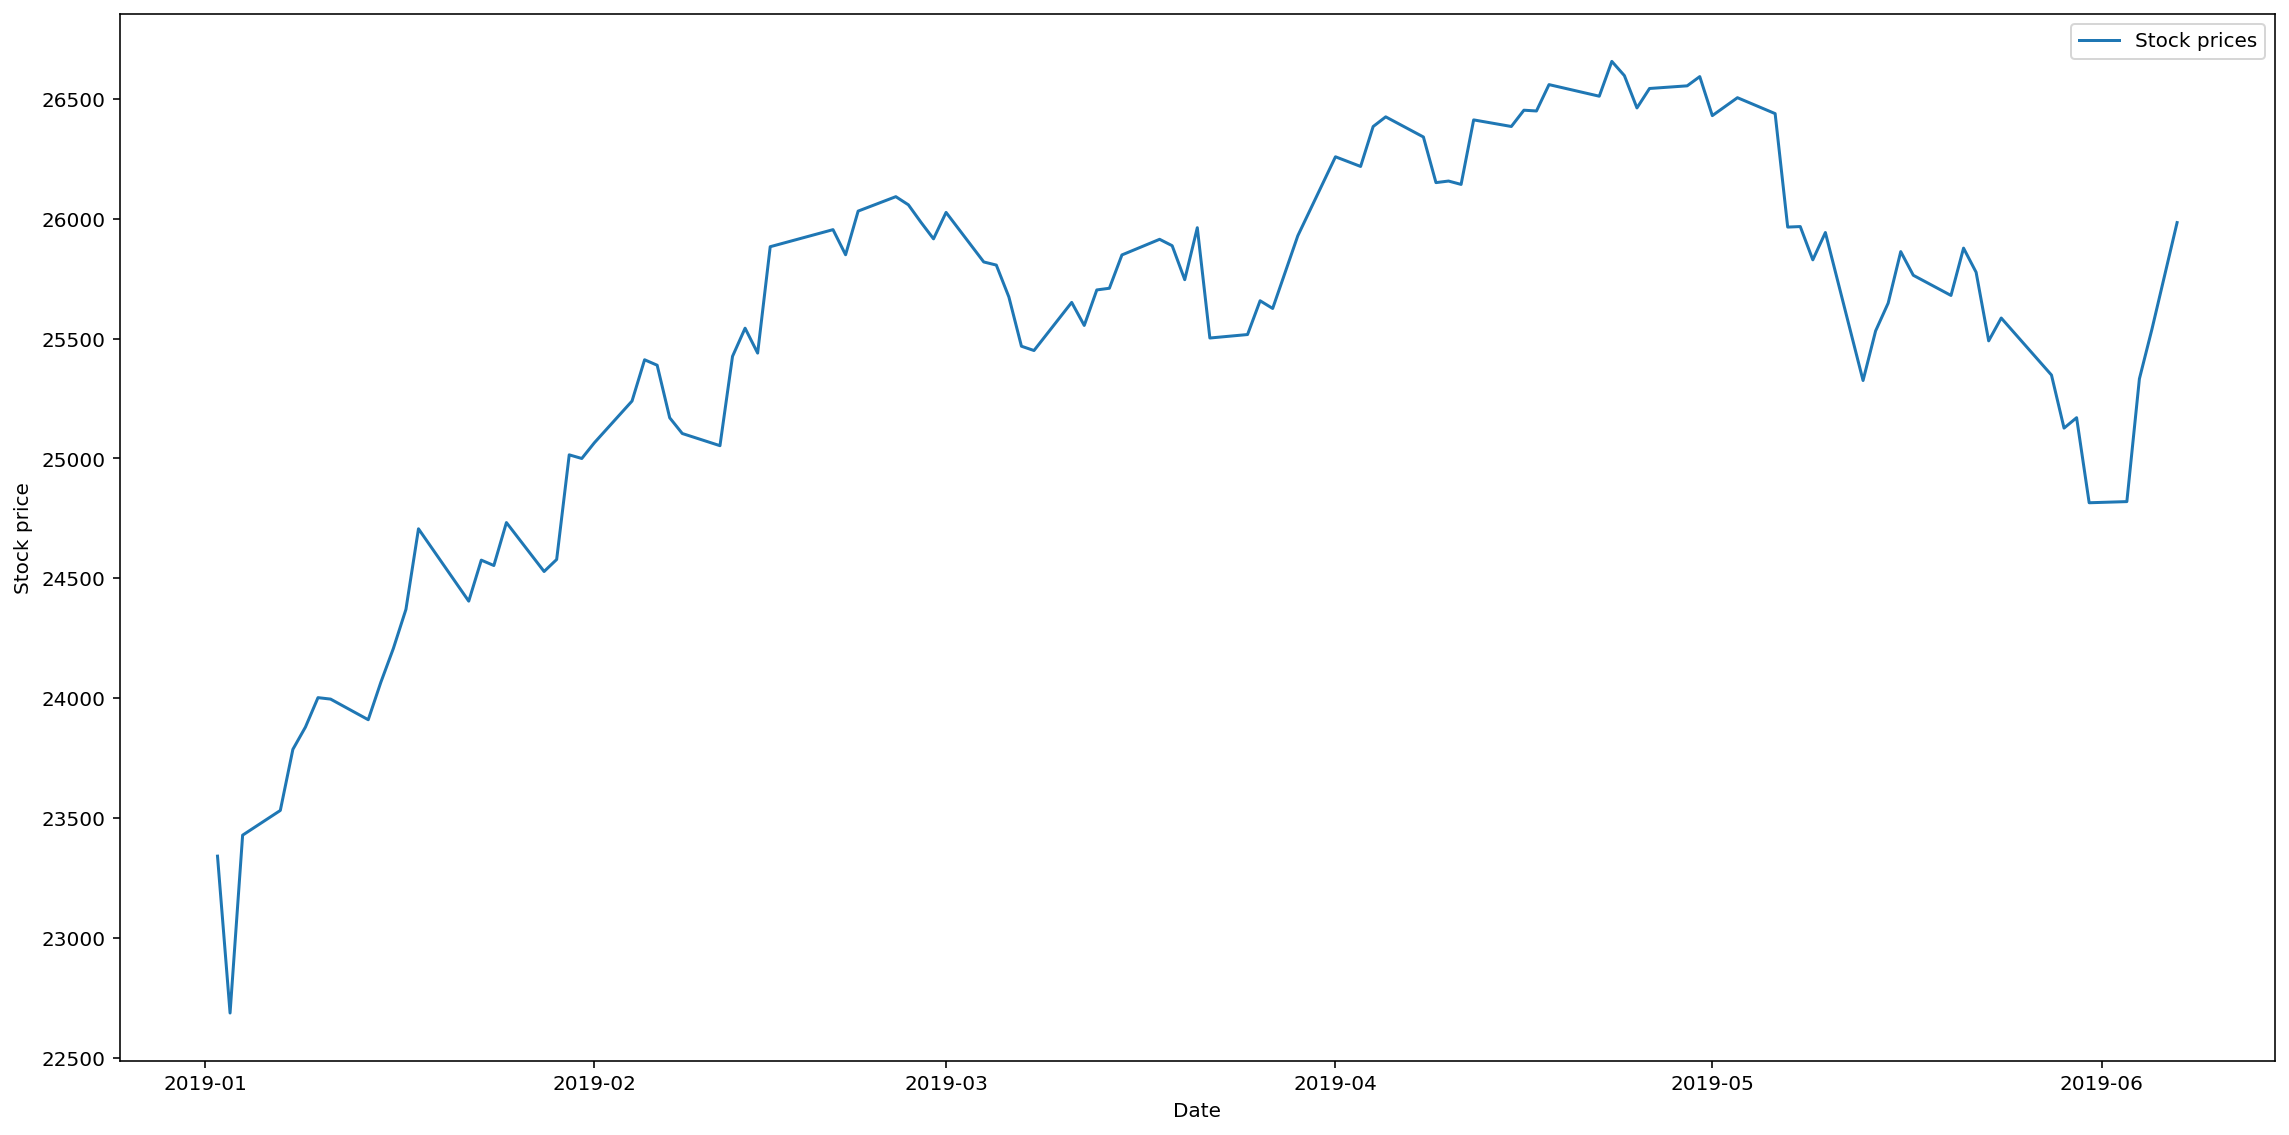

In [30]:
plot_strategy(evaluator, ticker_name='DJI', start='2019-01-01', end='2019-12-31')

## Cisco

In [31]:
%%time
best_individual = find_best_strategy(ticker_name='CSCO', start='2016-01-01', end='2018-12-31', ngen=13)

Running genetic algorithm ...
gen	nevals	min	max    	mean    	std    
0  	1000  	0  	22.9403	0.818935	3.27615
1  	647   	-0.472525	22.9905	1.84847 	4.6211 
2  	648   	-0.23705 	23.2476	3.72027 	6.06557
3  	669   	-2.91003 	24.3672	7.2376  	7.34777
4  	659   	-1.0451  	23.5796	10.9627 	7.7493 
5  	645   	-4.64185 	23.7555	13.8343 	7.63243
6  	642   	-11.562  	24.7099	15.5196 	7.7489 
7  	637   	0        	24.7099	17.0088 	7.71153
8  	663   	0        	25.4688	17.8656 	8.06539
9  	651   	0        	26.1799	18.5826 	7.95572
10 	655   	-1.27255 	26.1799	18.7243 	8.13871
11 	678   	0        	26.456 	18.4343 	8.51645
12 	642   	0        	26.5585	19.7999 	7.52639
13 	661   	0        	26.8785	19.3219 	8.18966
Net profit of buy and hold: 17.551374999999997
Running backtesting ...
Best individual: [0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,

In [32]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='CSCO', start='2019-01-01', end='2019-12-31')
results['CSCO'].append([percentage_profit, percentage_profit_bh])

Active rules: ['STO', 'MACD', 'BollingerBaender']
Active rules' parameters: [[241, 11], [8, 20, 60], [3, 1]]
Net profit of strategy: 0.402200
Net profit of buy and hold: 5.462050
Percentage profit of strategy: 0.986994%
Percentage profit of buy and hold: 13.403804%
Number of buy signals: 3
Number of sell signals: 3


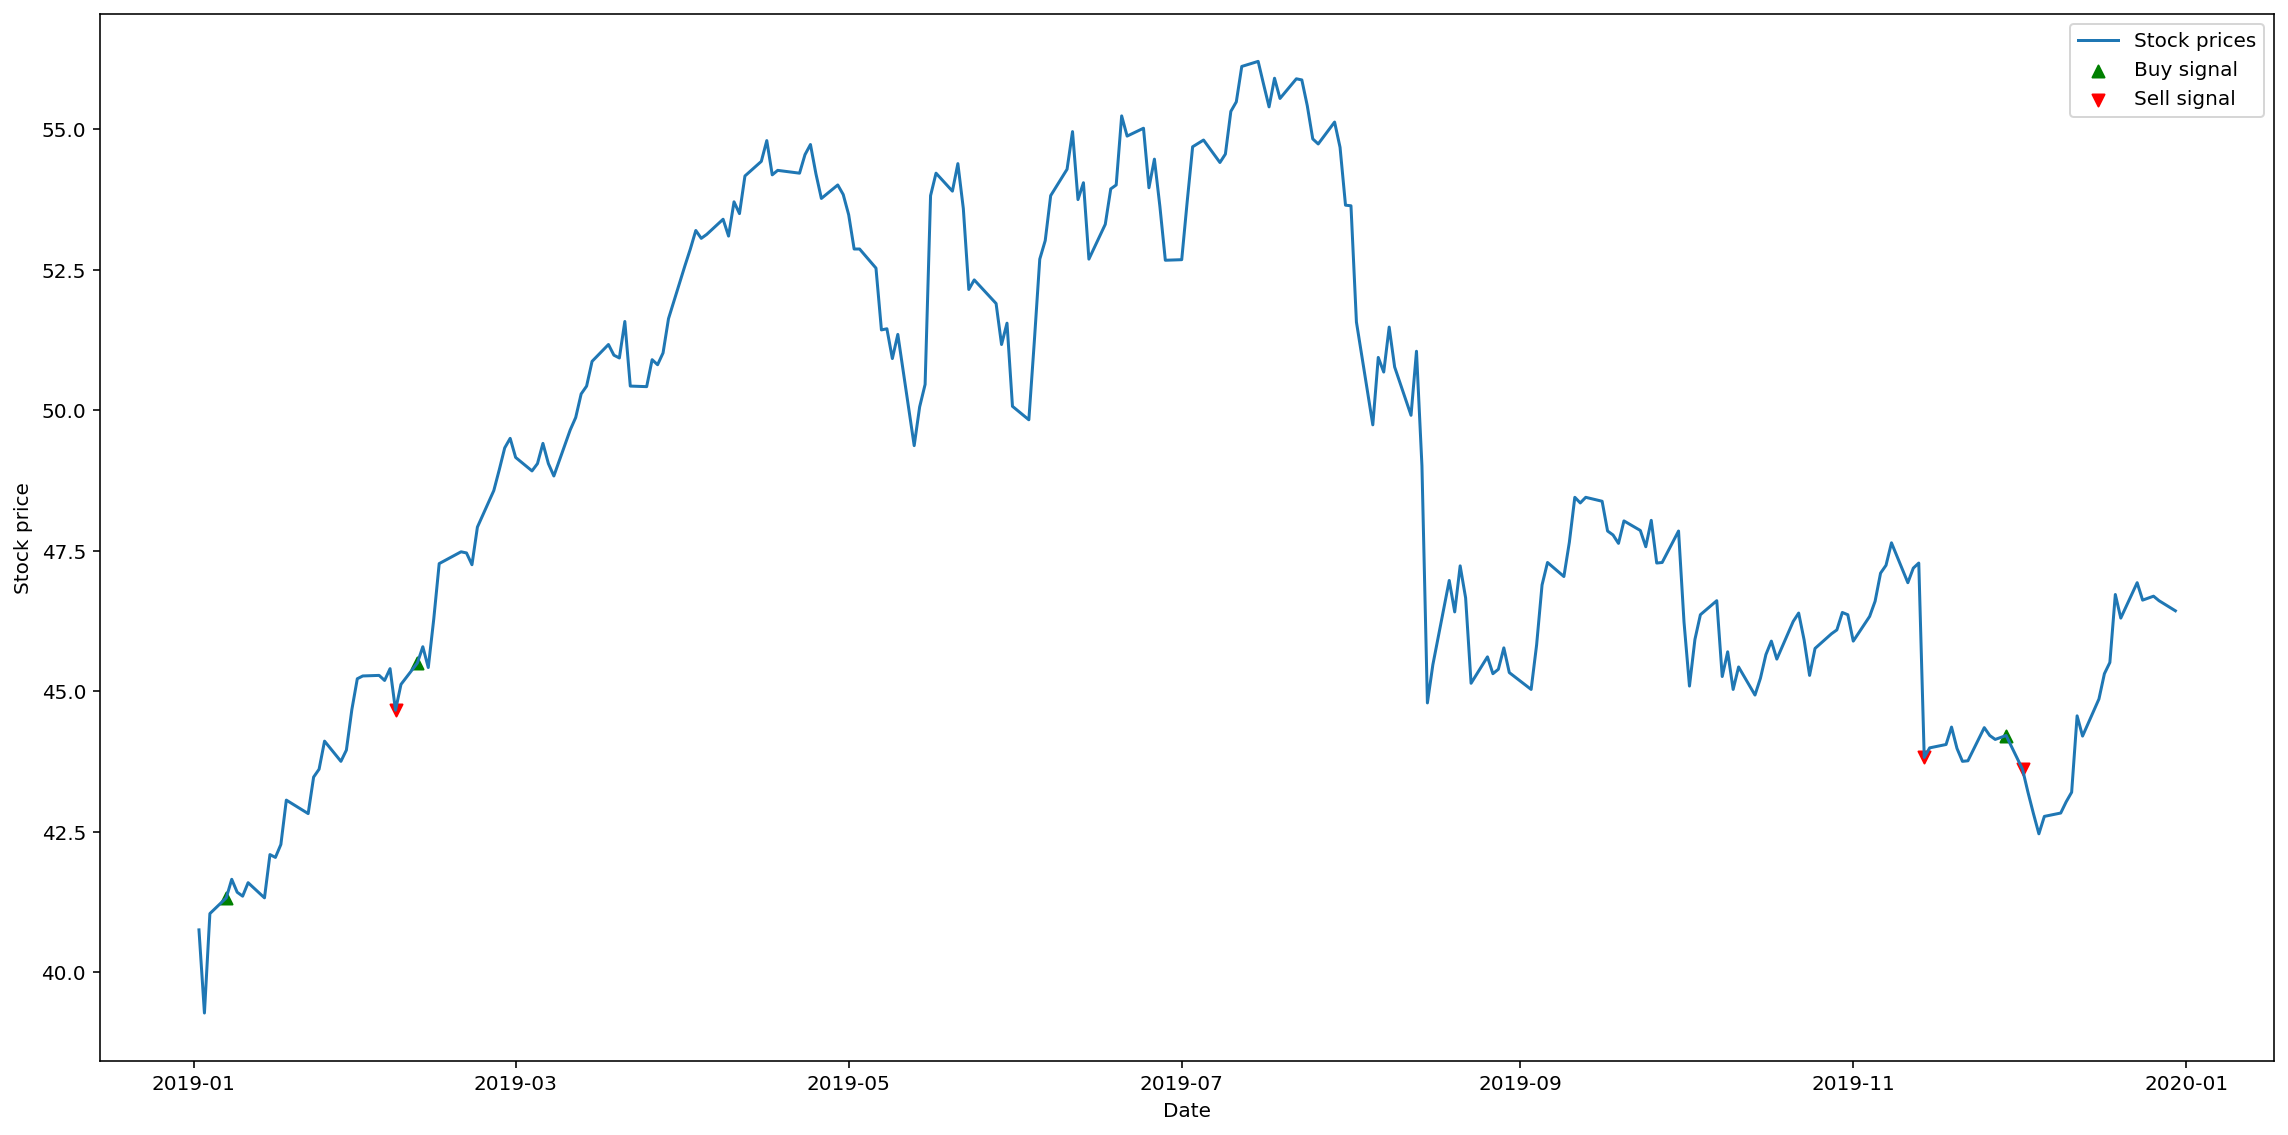

In [33]:
plot_strategy(evaluator, ticker_name='CSCO', start='2019-01-01', end='2019-12-31')

## DowDuPont

In [34]:
%%time
best_individual = find_best_strategy(ticker_name='DD', start='2016-01-01', end='2018-12-31', ngen=13)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-17.1555	42.1277	0.781402	4.94722
1  	647   	-6.17242	42.1277	1.69481 	7.11299
2  	648   	-17.1754	42.1277	3.27474 	9.52295
3  	669   	-12.6441	42.1277	6.41696 	12.4376
4  	659   	-17.7019	43.1712	10.6325 	14.787 
5  	645   	-6.17318	46.2787	16.5101 	16.018 
6  	642   	-15.9955	42.9025	22.0557 	15.6641
7  	637   	-4.50673	47.233 	24.5639 	15.9237
8  	663   	-0.9728 	47.233 	27.3831 	15.4799
9  	651   	-58.9545	47.233 	27.7615 	16.7539
10 	655   	-1.76315	47.233 	28.9517 	16.8041
11 	678   	-10.0573	47.9424	30.7814 	16.3197
12 	642   	-12.7472	48.5755	32.6166 	15.5788
13 	661   	-1.56228	48.5755	33.54   	15.8993
Net profit of buy and hold: 12.261875000000003
Running backtesting ...
Best individual: [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,

In [35]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='DD', start='2019-01-01', end='2019-12-31')
results['DD'].append([percentage_profit, percentage_profit_bh])

Active rules: ['ExponentialMovingAverage', 'STO', 'MACD', 'BollingerBaender']
Active rules' parameters: [[17], [47, 2], [43, 63, 7], [2, 0]]
Net profit of strategy: -0.730300
Net profit of buy and hold: -13.107875
Percentage profit of strategy: -0.987426%
Percentage profit of buy and hold: -17.722925%
Number of buy signals: 1
Number of sell signals: 1


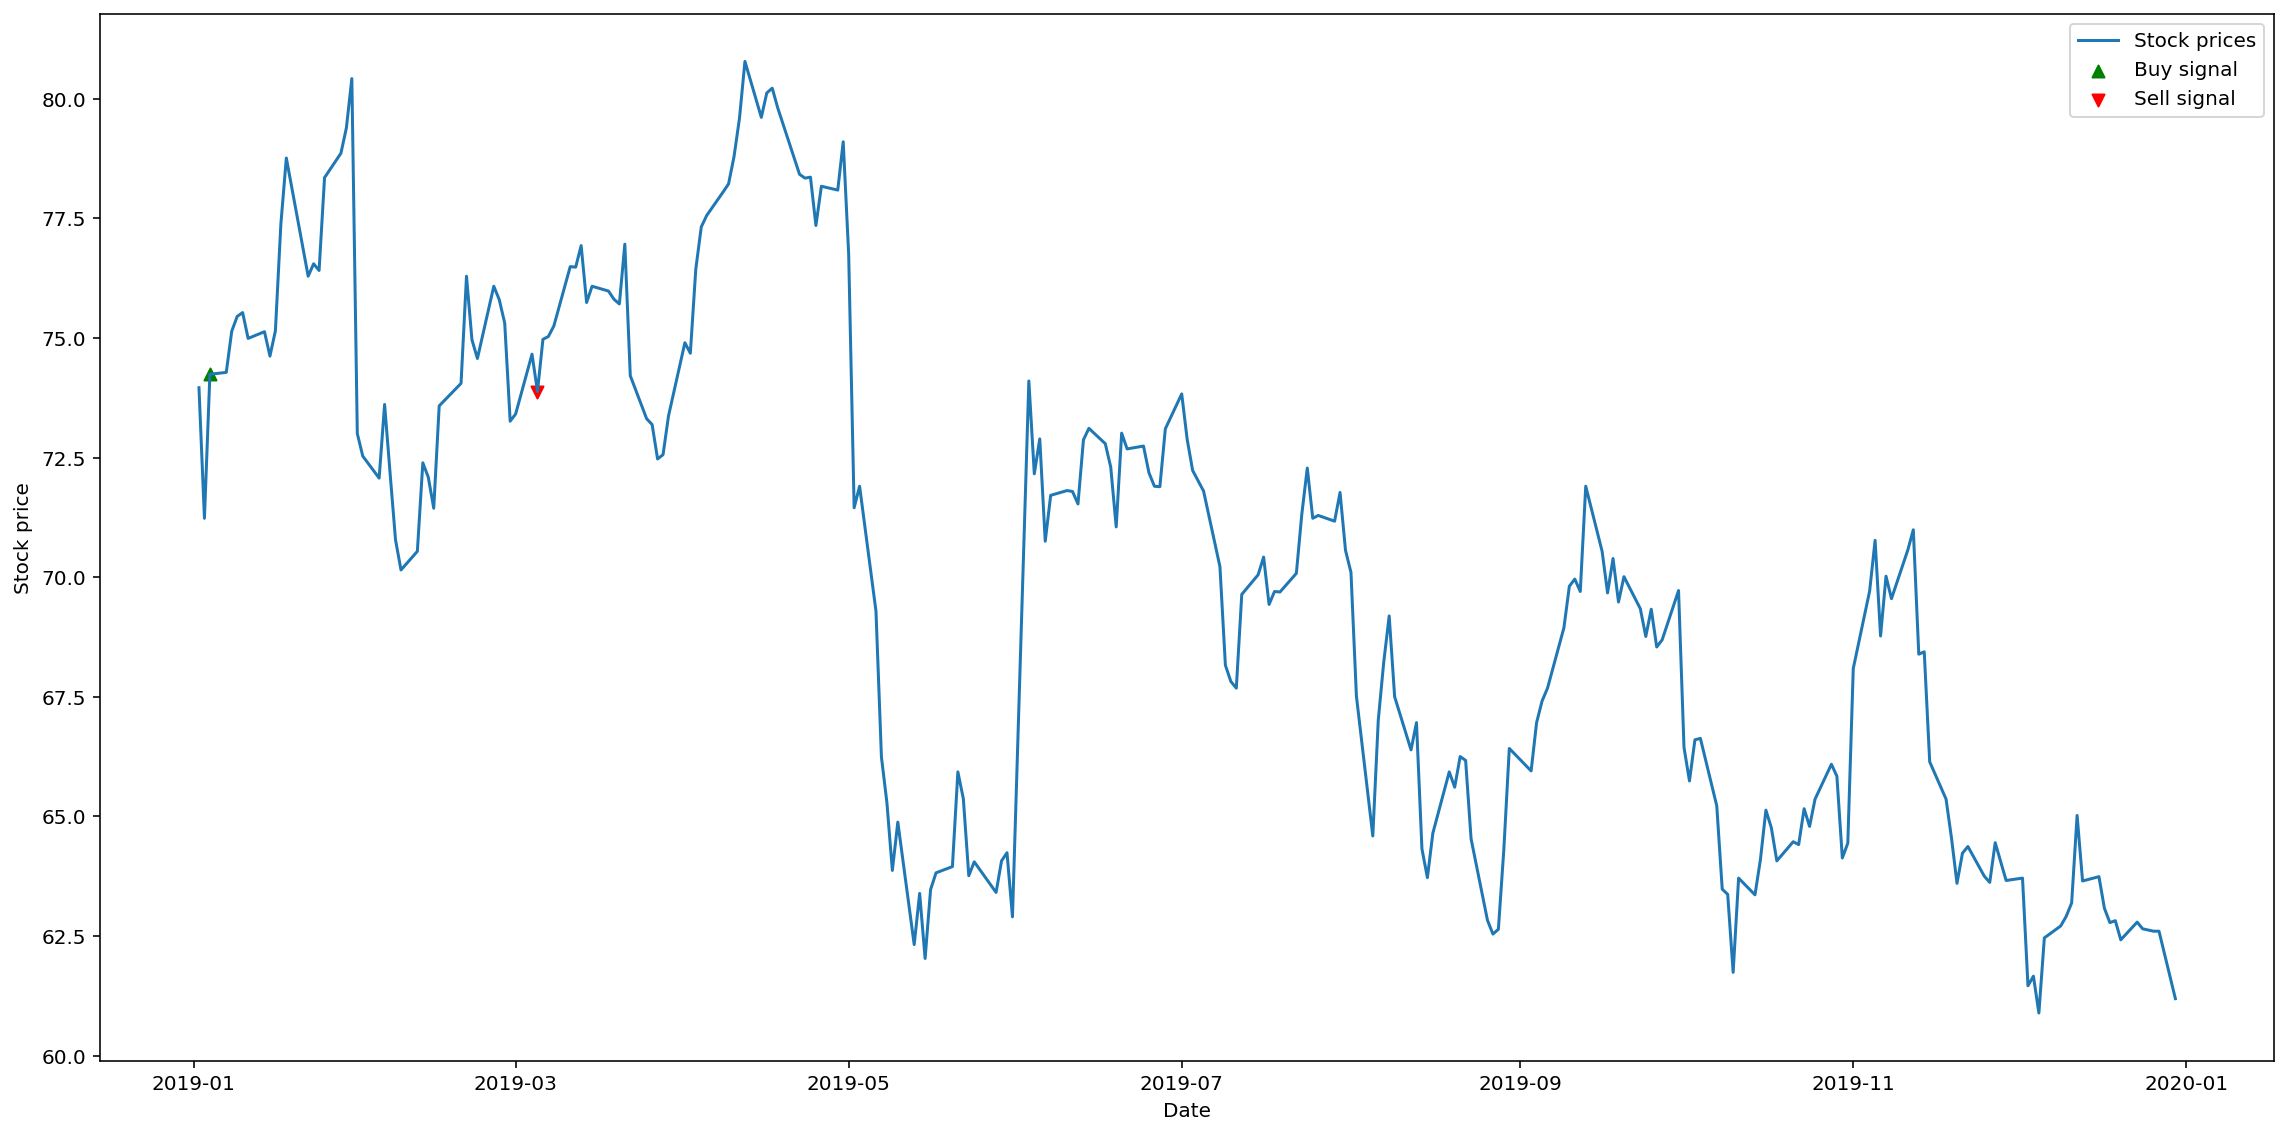

In [36]:
plot_strategy(evaluator, ticker_name='DD', start='2019-01-01', end='2019-12-31')

## JPMorgan Chase

In [37]:
%%time
best_individual = find_best_strategy(ticker_name='JPM', start='2016-01-01', end='2018-12-31', ngen=13)

Running genetic algorithm ...
gen	nevals	min    	max    	mean   	std    
0  	1000  	-7.9801	52.7565	1.86022	8.60059
1  	647   	-3.50157	53.8181	4.39047	12.6044
2  	648   	-8.32092	53.8181	9.34923	17.5338
3  	669   	-3.50157	54.9119	17.6237	21.4279
4  	659   	-5.17345	56.6611	26.4945	21.9177
5  	645   	-9.36283	56.7335	34.5419	20.4109
6  	642   	-11.2841	56.7335	38.4601	19.963 
7  	637   	-11.2841	57.3034	40.3303	20.4252
8  	663   	-3.50157	61.3508	42.9047	19.8277
9  	651   	-5.34433	57.3034	42.7154	21.1397
10 	655   	-5.42645	59.6668	43.6312	20.9944
11 	678   	-12.4325	59.6668	44.5572	20.3866
12 	642   	-11.2841	59.6668	44.9907	20.4715
13 	661   	-5.34433	59.6668	46.1471	19.5905
Net profit of buy and hold: 35.241775
Running backtesting ...
Best individual: [0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1

In [38]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='JPM', start='2019-01-01', end='2019-12-31')
results['JPM'].append([percentage_profit, percentage_profit_bh])

Active rules: ['STO', 'MACD', 'BollingerBaender']
Active rules' parameters: [[84, 182], [17, 9, 52], [12, 0]]
Net profit of strategy: 0.000000
Net profit of buy and hold: 40.648000
Percentage profit of strategy: 0.000000%
Percentage profit of buy and hold: 43.339375%
Number of buy signals: 0
Number of sell signals: 0


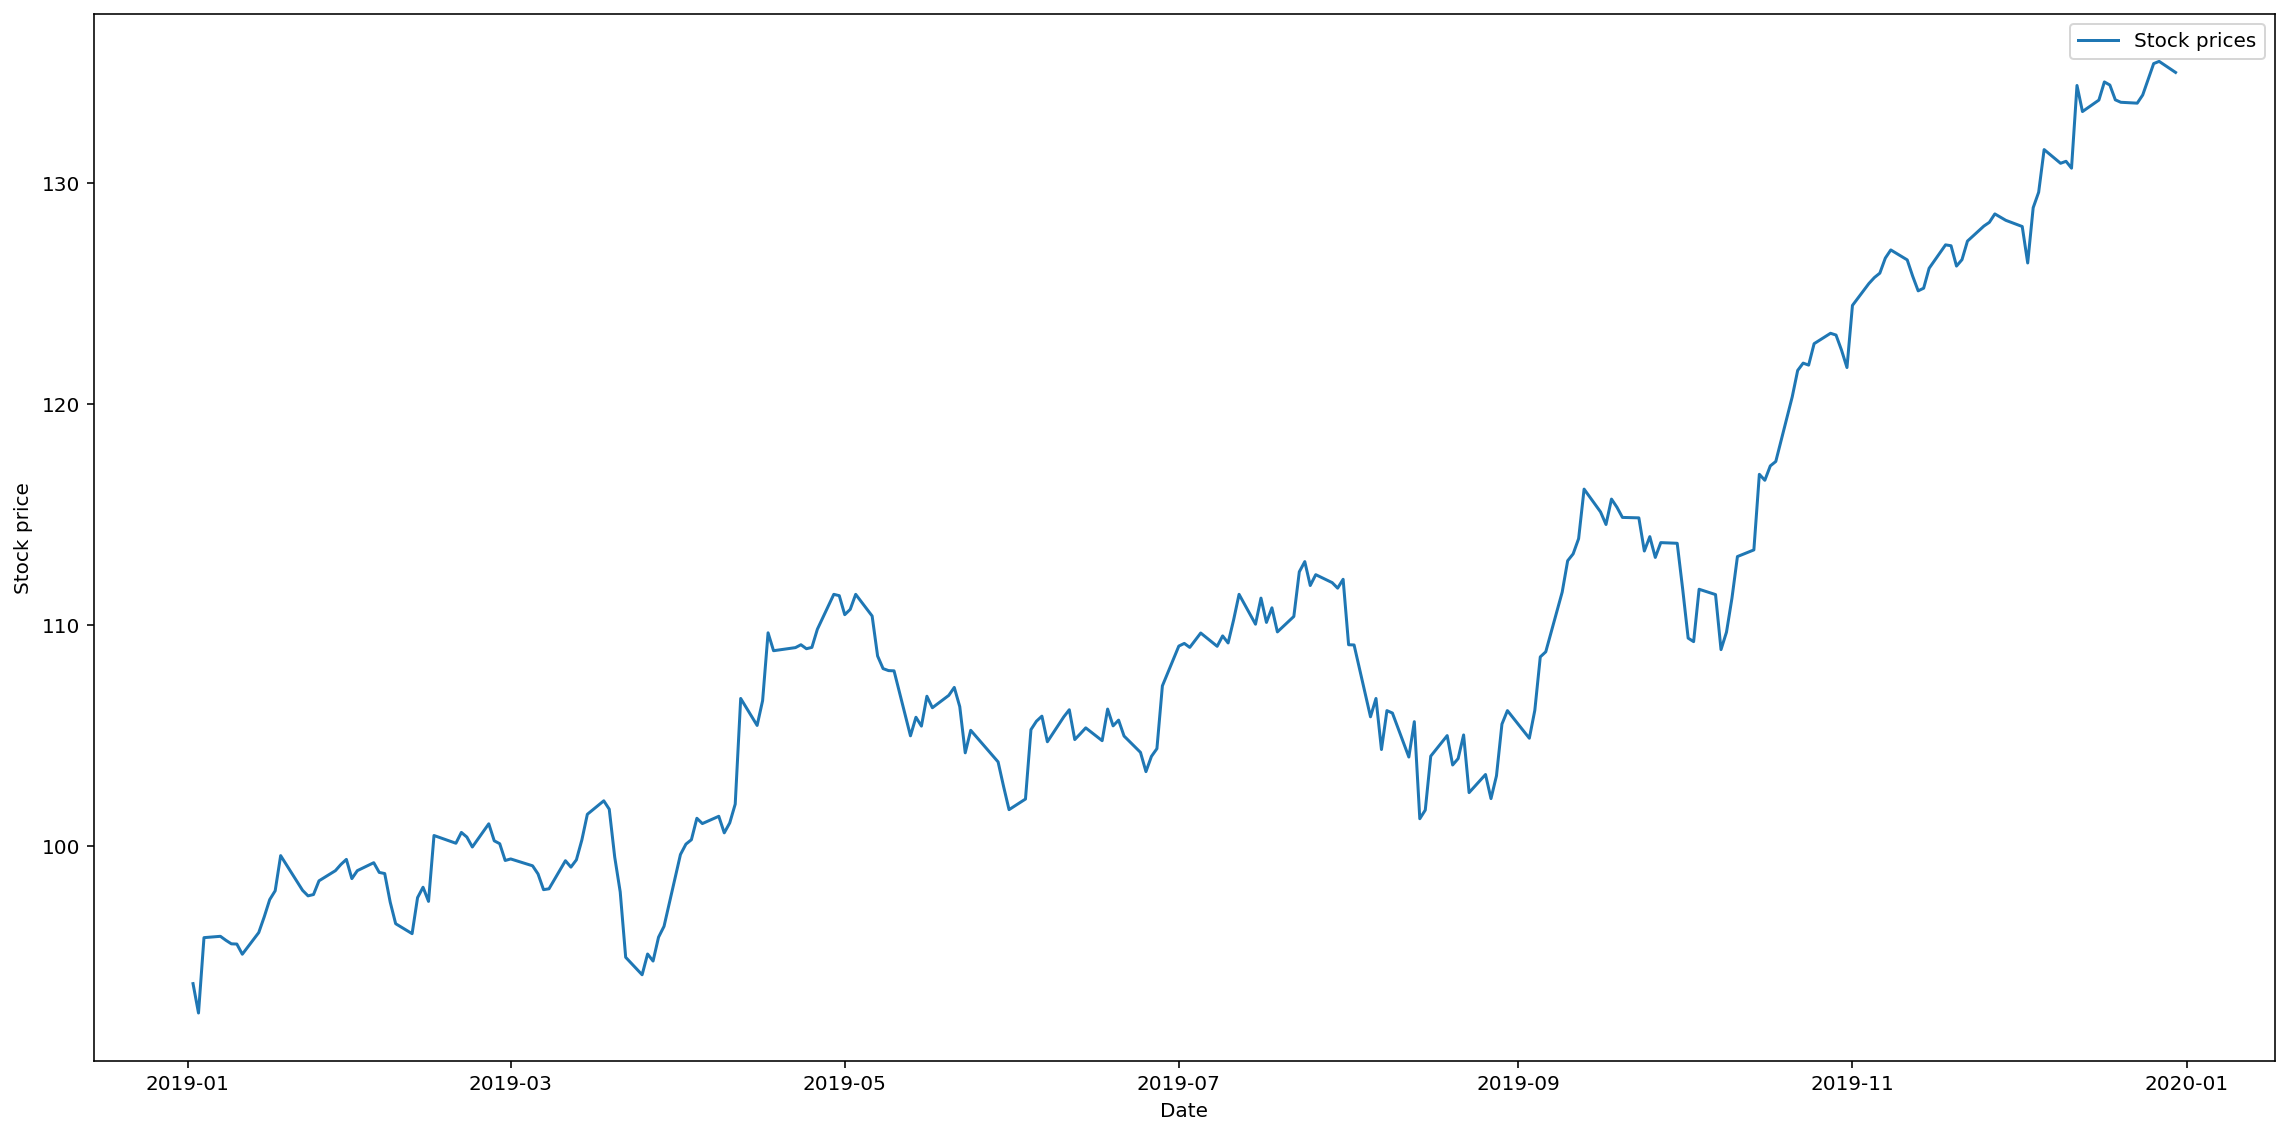

In [39]:
plot_strategy(evaluator, ticker_name='JPM', start='2019-01-01', end='2019-12-31')

## Microsoft

In [40]:
%%time
best_individual = find_best_strategy(ticker_name='MSFT', start='2016-01-01', end='2018-12-31', ngen=13)

Running genetic algorithm ...
gen	nevals	min     	max   	mean    	std   
0  	1000  	-4.76458	55.992	0.895151	6.5895
1  	647   	-4.77047	53.7259	1.6356  	8.50412
2  	648   	-8.56442	55.2329	3.31081 	11.8643
3  	669   	-5.51188	55.2329	6.90838 	16.2892
4  	659   	-7.8378 	59.9175	11.7671 	19.9292
5  	645   	-6.2048 	59.9175	20.856  	23.0148
6  	642   	-4.80055	59.9175	28.4713 	23.3931
7  	637   	-6.18243	59.1161	34.2094 	23.0589
8  	663   	-7.9378 	59.1161	36.6605 	22.7748
9  	651   	-9.64447	59.1161	37.7918 	23.0359
10 	655   	-6.438  	59.7151	37.1945 	24.0889
11 	678   	-15.8334	61.7785	37.9421 	24.3663
12 	642   	-5.29177	61.9489	41.4963 	22.9767
13 	661   	-4.24542	61.9489	43.5465 	23.1983
Net profit of buy and hold: 47.639275000000005
Running backtesting ...
Best individual: [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 

In [41]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='MSFT', start='2019-01-01', end='2019-12-31')
results['MSFT'].append([percentage_profit, percentage_profit_bh])

Active rules: ['STO', 'MACD', 'BollingerBaender']
Active rules' parameters: [[123, 66], [9, 62, 28], [4, 1]]
Net profit of strategy: 33.924825
Net profit of buy and hold: 56.851975
Percentage profit of strategy: 34.316028%
Percentage profit of buy and hold: 57.507561%
Number of buy signals: 1
Number of sell signals: 1


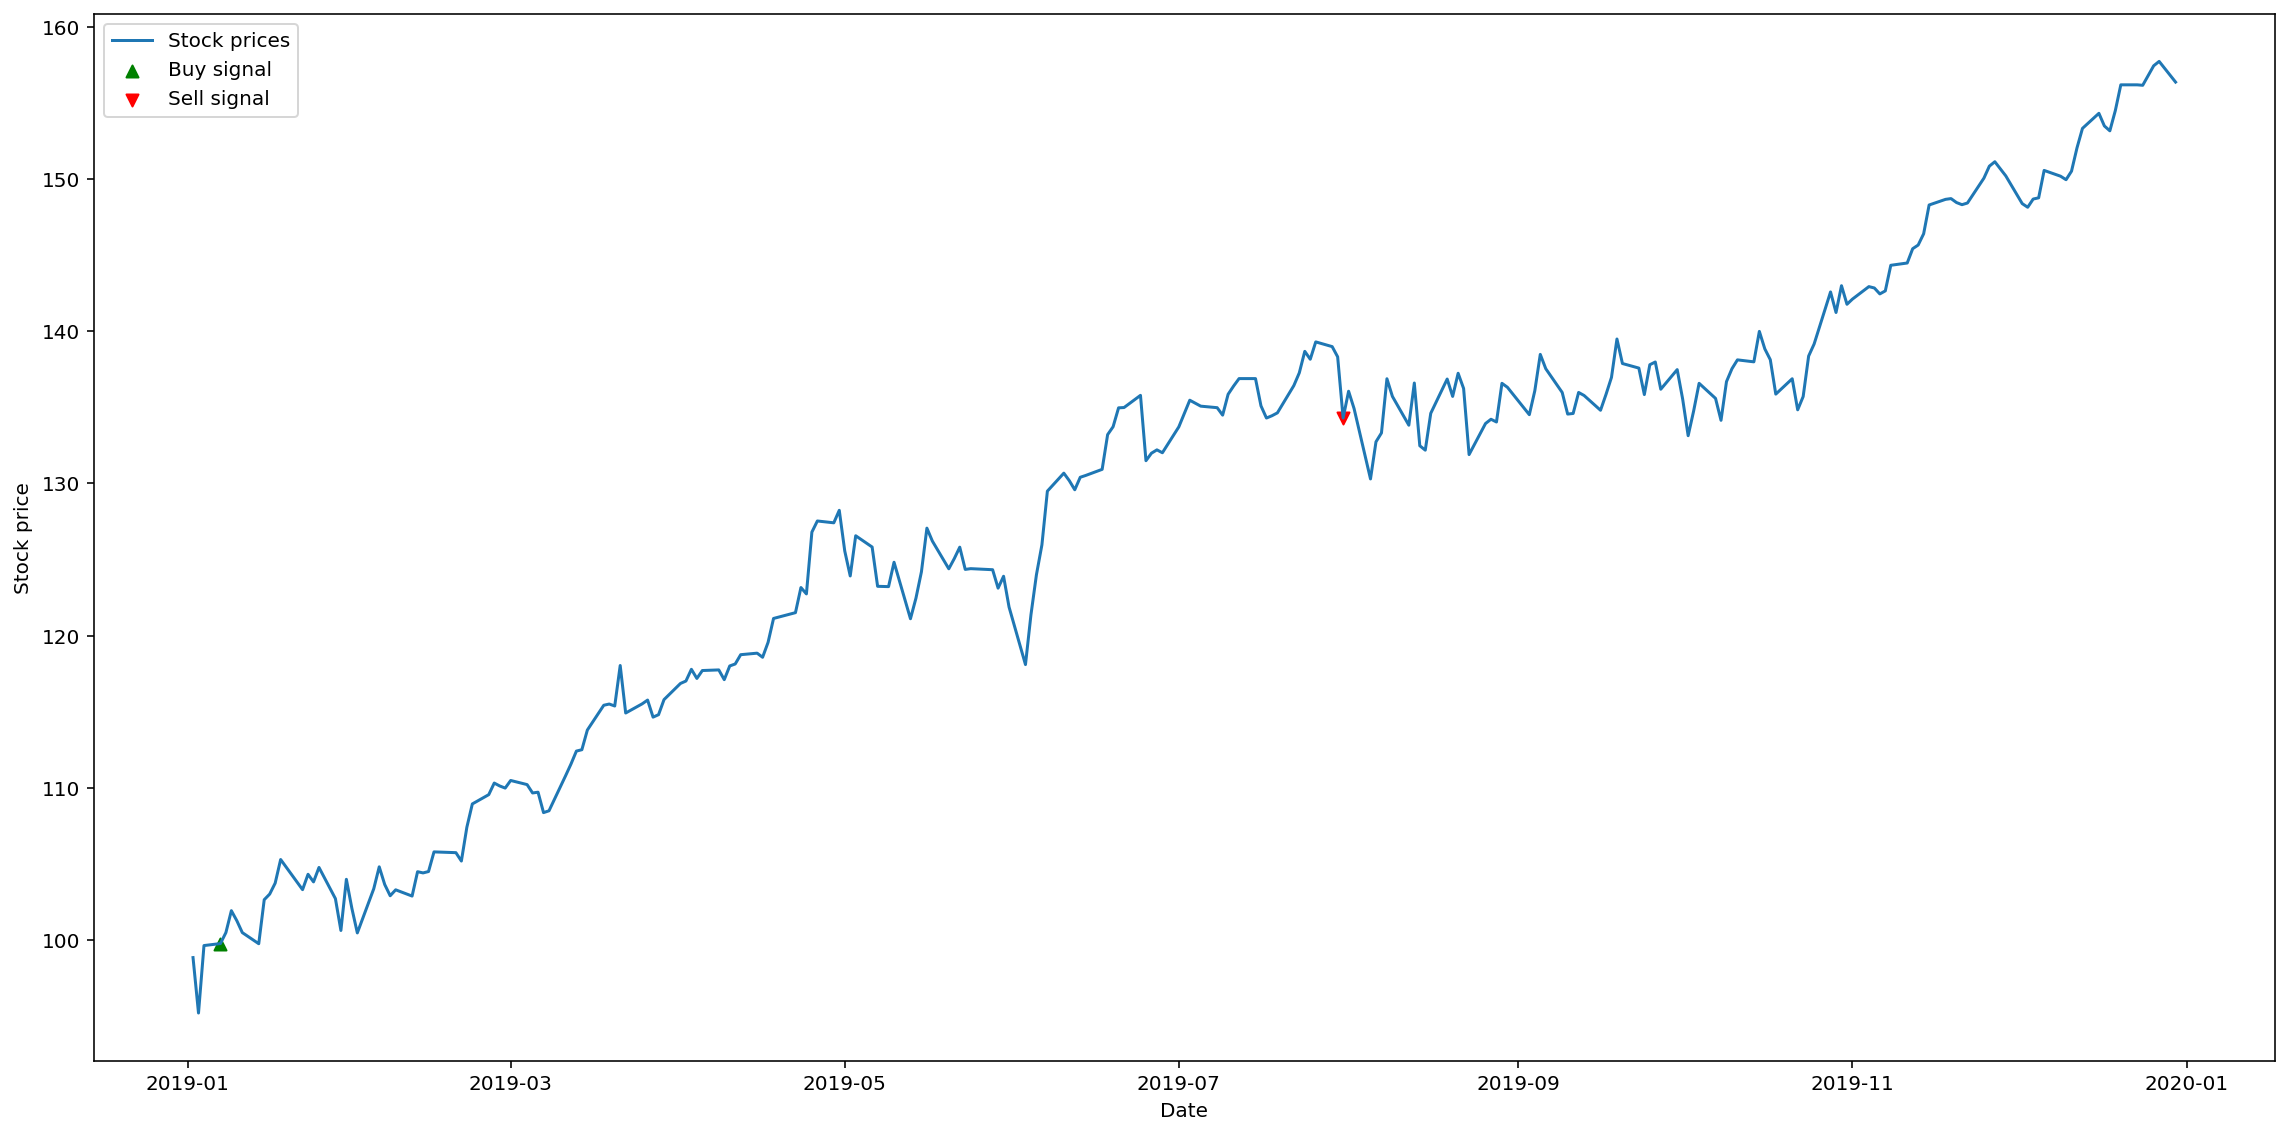

In [42]:
plot_strategy(evaluator, ticker_name='MSFT', start='2019-01-01', end='2019-12-31')

## Nike

In [43]:
%%time
best_individual = find_best_strategy(ticker_name='NKE', start='2016-01-01', end='2018-12-31', ngen=13)

Running genetic algorithm ...
gen	nevals	min     	max    	mean      	std   
0  	1000  	-13.9924	23.3106	-0.0524321	2.1362
1  	647   	-8.16488	22.2549	0.329252  	2.41967
2  	648   	-8.1662 	22.2549	0.553018  	3.04078
3  	669   	-18.691 	26.1226	1.13677   	4.21422
4  	659   	-11.2954	26.1226	2.20891   	5.52591
5  	645   	-11.3415	28.5316	3.95386   	6.92862
6  	642   	-27.3615	28.5316	6.3016    	8.21148
7  	637   	-14.8534	28.5316	9.07512   	8.61628
8  	663   	-13.4242	28.5316	10.7351   	9.06956
9  	651   	-14.3543	29.8602	12.4137   	9.47545
10 	655   	-19.4687	29.8602	14.26     	10.0563
11 	678   	-9.57343	29.8602	15.7948   	10.1501
12 	642   	-16.6009	29.8602	18.6616   	9.40039
13 	661   	-15.3557	29.8602	19.641    	10.0089
Net profit of buy and hold: 13.604675
Running backtesting ...
Best individual: [1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0

In [44]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='NKE', start='2019-01-01', end='2019-12-31')
results['NKE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['STO', 'MACD', 'BollingerBaender']
Active rules' parameters: [[222, 51], [16, 34, 39], [21, 0]]
Net profit of strategy: 0.000000
Net profit of buy and hold: 26.878025
Percentage profit of strategy: 0.000000%
Percentage profit of buy and hold: 36.950818%
Number of buy signals: 0
Number of sell signals: 0


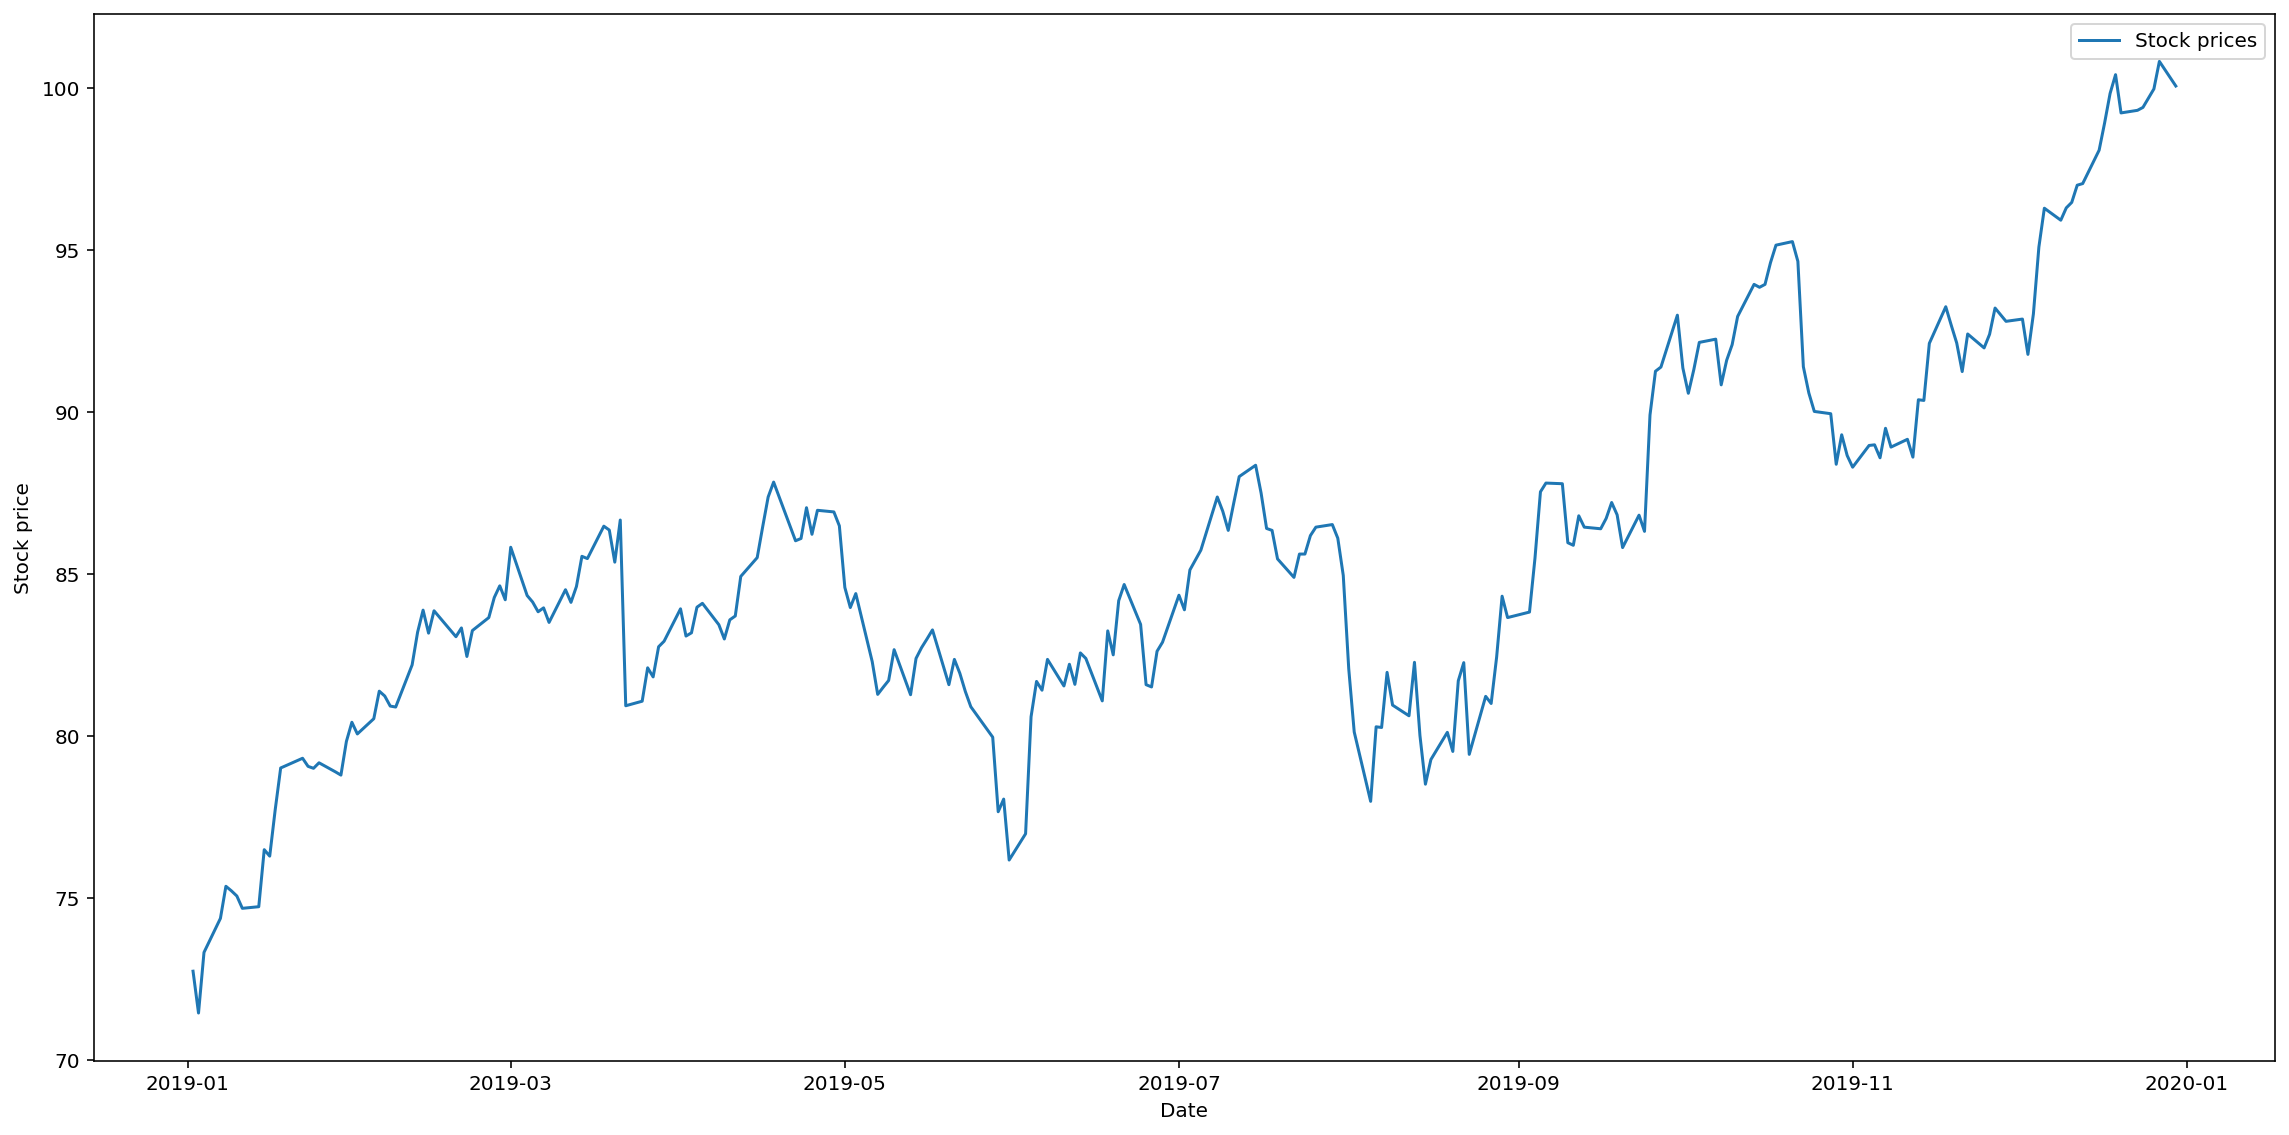

In [45]:
plot_strategy(evaluator, ticker_name='NKE', start='2019-01-01', end='2019-12-31')

## UnitedHealth

In [46]:
%%time
best_individual = find_best_strategy(ticker_name='UNH', start='2016-01-01', end='2018-12-31', ngen=13)

Running genetic algorithm ...
gen	nevals	min     	max    	mean   	std    
0  	1000  	-3.77118	145.483	2.17108	14.6639
1  	647   	0       	148.346	5.67659	24.366 
2  	648   	0       	148.346	11.3106	32.8308
3  	669   	0       	148.908	24.7961	46.5398
4  	659   	-4.3728 	151.482	44.143 	55.7537
5  	645   	-6.4515 	154.502	69.7301	59.3876
6  	642   	-27.3482	154.502	90.6377	57.2043
7  	637   	-20.7099	154.502	100.377	57.4355
8  	663   	-8.1658 	154.502	106.226	57.0744
9  	651   	-1.43535	158.567	110.413	57.1268
10 	655   	0       	158.567	110.803	58.0582
11 	678   	0       	158.567	109.89 	59.9319
12 	642   	0       	158.567	118.302	55.1676
13 	661   	0       	158.567	117.592	56.9645
Net profit of buy and hold: 130.18222500000002
Running backtesting ...
Best individual: [1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,

In [47]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='UNH', start='2019-01-01', end='2019-12-31')
results['UNH'].append([percentage_profit, percentage_profit_bh])

Active rules: ['STO', 'MACD', 'BollingerBaender']
Active rules' parameters: [[76, 2], [8, 40, 36], [14, 0]]
Net profit of strategy: -2.070575
Net profit of buy and hold: 52.403650
Percentage profit of strategy: -0.875841%
Percentage profit of buy and hold: 22.166427%
Number of buy signals: 1
Number of sell signals: 1


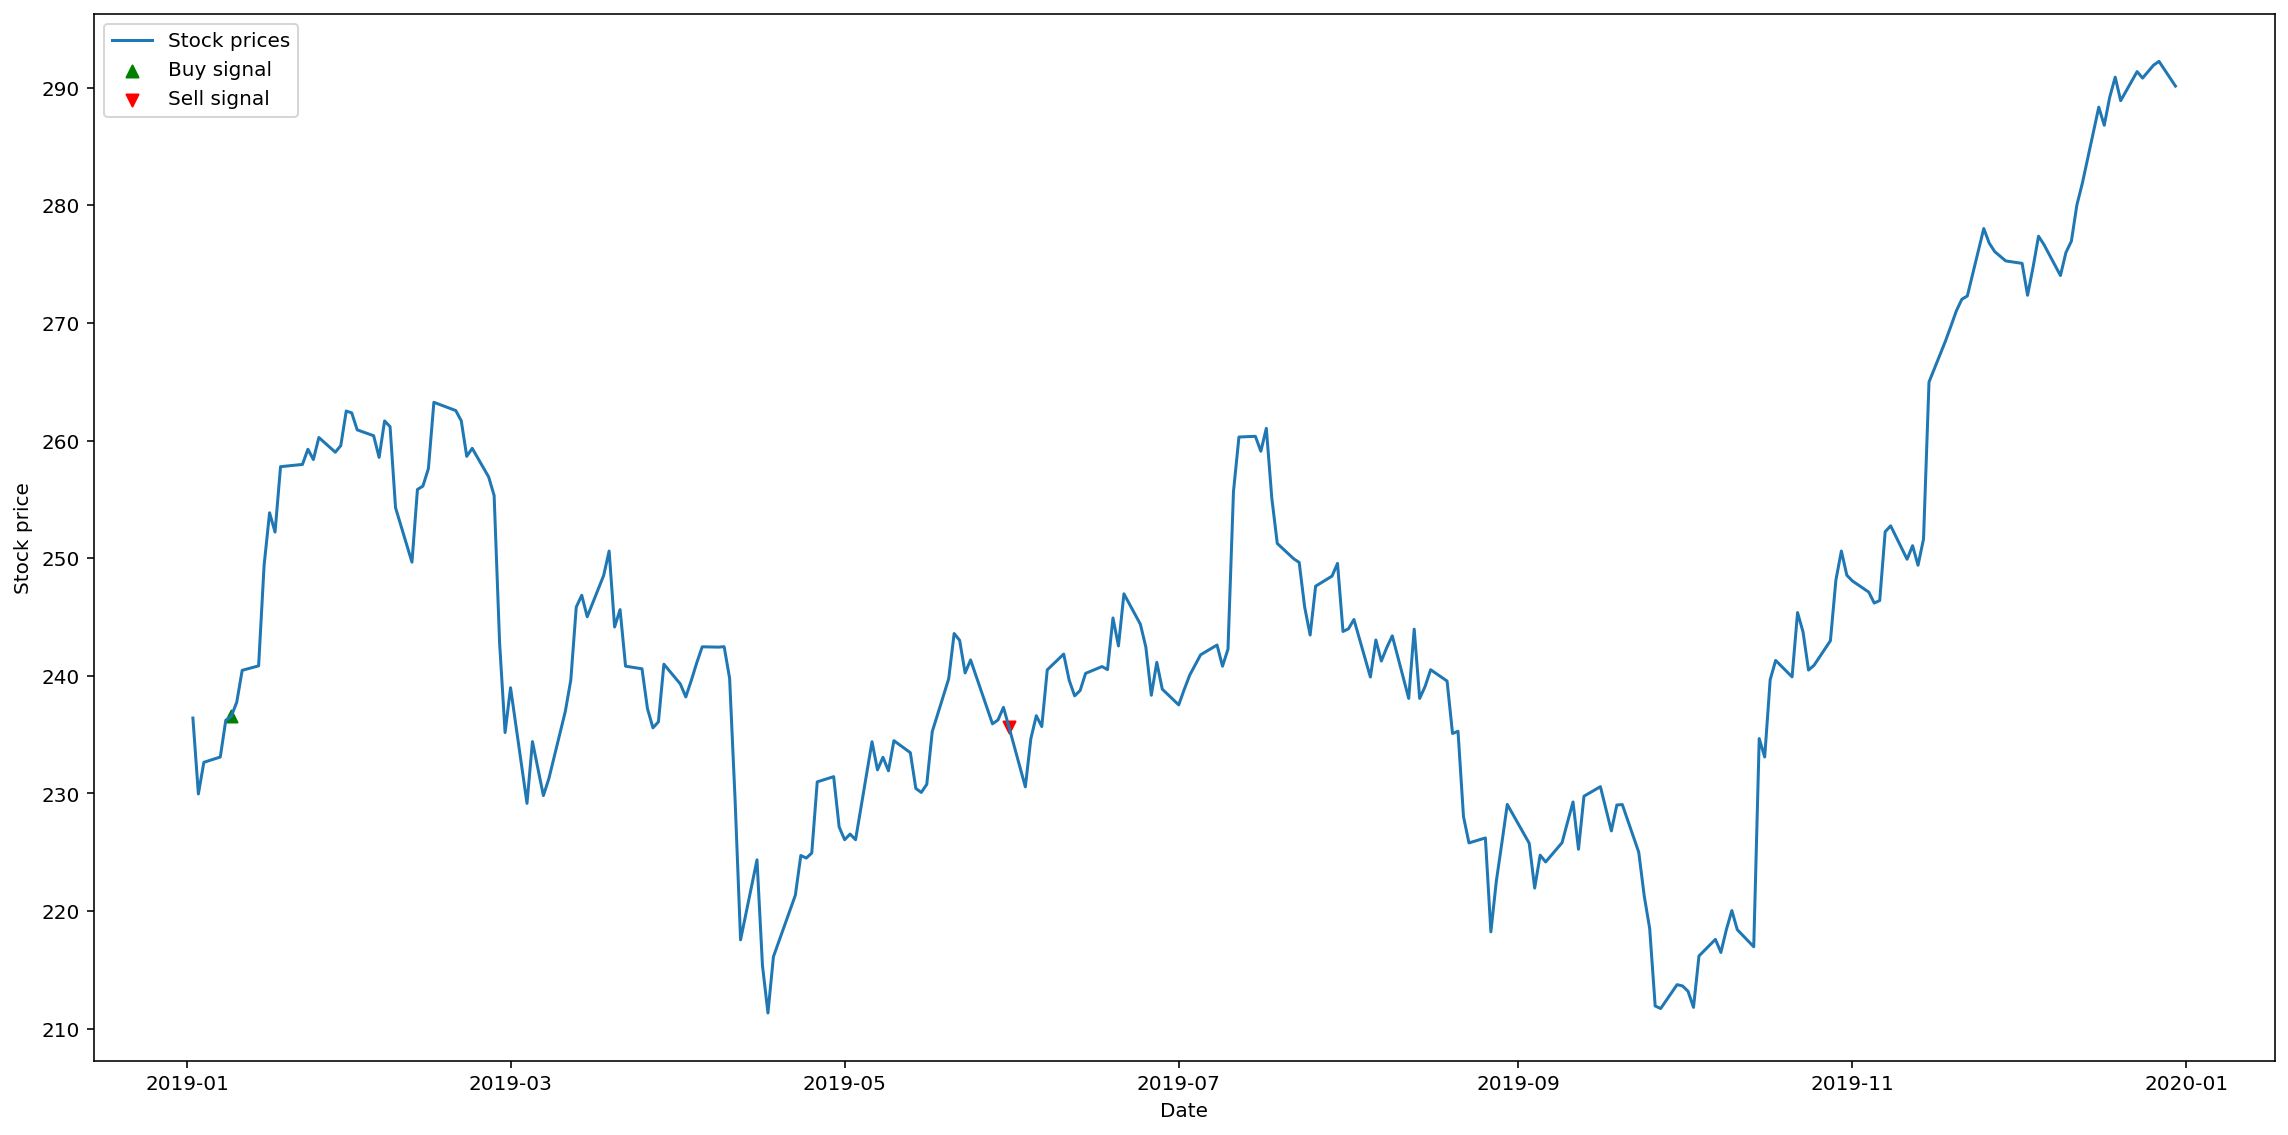

In [48]:
plot_strategy(evaluator, ticker_name='UNH', start='2019-01-01', end='2019-12-31')

# Results

In [49]:
results_df = pd.DataFrame(results)
results_df

,EXS1.DE,ADS.DE,ALV.DE,BAS.DE,DBK.DE,DTE.DE,SAP.DE,DJI,CSCO,DD,JPM,MSFT,NKE,UNH
0,"[0.0, 24.010750329091714]","[34.392326455085744, 58.64860659414599]","[19.49390476190477, 29.842999999999996]","[0.0, 15.491510365251738]","[0.0, -2.060810810810815]","[0.0, 2.4338235294117707]","[18.630472592059473, 39.54596977329974]","[0.0, 10.796113655545895]","[0.9869938650306107, 13.403803680981593]","[-0.9874256354786363, -17.72292455381287]","[0.0, 43.339375199914684]","[34.31602771596196, 57.507561197653246]","[0.0, 36.95081798185318]","[-0.8758407004779895, 22.166426970094328]"


In [50]:
ps_results = list()
bh_results = list()
for col in results_df.columns:
    results_df[col].apply(lambda result: ps_results.append(result[0]))
    results_df[col].apply(lambda result: bh_results.append(result[1]))

In [51]:
np.mean(ps_results)

7.568318503863281

In [52]:
np.mean(bh_results)

23.882430279472867